# Figure 1 - Overall Non-B DNA landscape across 130 phased haplotype assemblies

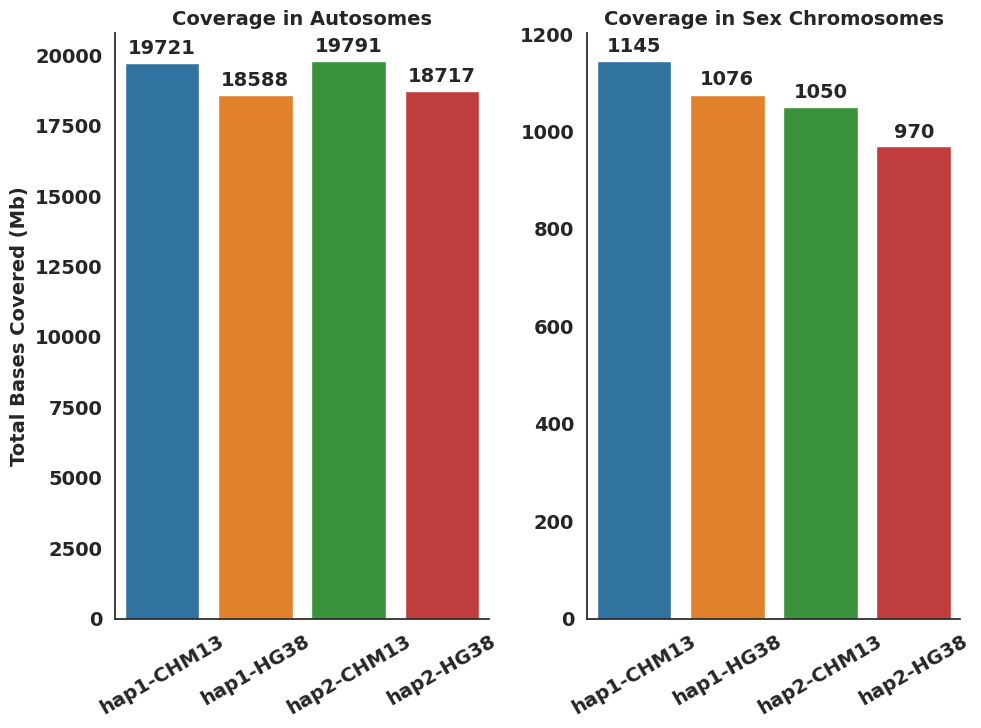

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# =========================================================
# Part 1: Load and Prepare Data
# =========================================================

def load_data(batches, reference):
    dfs = []
    for batch in batches:
        file_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch{batch}_{reference}_collapsed_summary_metrics_chr.csv'
        df = pd.read_csv(file_path)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def prepare_coverage_data(data):
    data = data.copy()
    split_cols = data['Sample_Haplotype_Chromosome'].str.split('|', expand=True)
    data['Sample_Haplotype'] = split_cols[0]
    data['Chromosome'] = split_cols[2]
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

def load_quad_data(reference):
    quad_path = f'/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/{reference}_Q19_filtered/verkko_batch123_{reference}_collapsed_quadron_summary_metrics_combined_chr.csv'
    quad_df = pd.read_csv(quad_path)
    quad_df['Label'] = reference.upper()
    return quad_df

def prepare_quad_data(data):
    data = data.copy()
    data['Haplotype'] = data['Sample_Haplotype'].str.extract(r'(hap\d)')[0]
    return data

batches = [1, 2, 3]
hg38_data = load_data(batches, 'hg38')
chm13_data = load_data(batches, 'chm13')
hg38_quad = load_quad_data('hg38')
chm13_quad = load_quad_data('chm13')

hg38_data = prepare_coverage_data(hg38_data)
chm13_data = prepare_coverage_data(chm13_data)
hg38_quad = prepare_quad_data(hg38_quad)
chm13_quad = prepare_quad_data(chm13_quad)

# =========================================================
# Part 2: Combine and Summarize
# =========================================================

# Group motif types
hg38_base = hg38_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_base = chm13_data.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
hg38_quad = hg38_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()
chm13_quad = chm13_quad.groupby(['Sample_Haplotype', 'Haplotype', 'Chromosome'])['Total Bases Covered'].sum().reset_index()

# Add genome ref labels
hg38_base['Reference Genome'] = 'HG38'
hg38_quad['Reference Genome'] = 'HG38'
chm13_base['Reference Genome'] = 'CHM13'
chm13_quad['Reference Genome'] = 'CHM13'

# Combine
all_data = pd.concat([hg38_base, chm13_base, hg38_quad, chm13_quad], ignore_index=True)

# Annotate chromosome type
autosomes = [f'chr{i}' for i in range(1, 23)]
all_data['Chromosome_Type'] = np.where(all_data['Chromosome'].isin(autosomes), 'Autosomes', 'Sex Chromosomes')

# Convert to Mb
all_data['Total Bases Covered (Mb)'] = all_data['Total Bases Covered'] / 1e6

# =========================================================
# Part 3: Summarize Total by Hap × Ref × ChromType
# =========================================================

summed = all_data.groupby(['Haplotype', 'Reference Genome', 'Chromosome_Type'])['Total Bases Covered (Mb)'].sum().reset_index()
summed['Group'] = summed['Haplotype'] + '-' + summed['Reference Genome']

# =========================================================
# Part 4: Plot (Vertical bars)
# =========================================================

sns.set(style="white")  # Clean white background
custom_palette = {
    'hap1-CHM13': '#1f77b4',
    'hap1-HG38': '#ff7f0e',
    'hap2-CHM13': '#2ca02c',
    'hap2-HG38': '#d62728'
}

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=False)

for i, chrom_type in enumerate(['Autosomes', 'Sex Chromosomes']):
    ax = axes[i]
    data = summed[summed['Chromosome_Type'] == chrom_type].copy()

    order = ['hap1-CHM13', 'hap1-HG38', 'hap2-CHM13', 'hap2-HG38']
    data['Group'] = pd.Categorical(data['Group'], categories=order, ordered=True)

    sns.barplot(data=data, x='Group', y='Total Bases Covered (Mb)',
                hue='Group', palette=custom_palette,
                order=order, ax=ax, dodge=False, legend=False)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height * 1.01,
                f"{height:.0f}", ha='center', va='bottom', fontsize=14, fontweight='bold')

    ax.set_title(f'Coverage in {chrom_type}', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Total Bases Covered (Mb)' if i == 0 else '', fontweight='bold', fontsize = 14)
    ax.spines[['top', 'right']].set_visible(False)
    ax.tick_params(axis='x', labelrotation=30)
    
    # Bold tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(14)

    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(14)

#plt.suptitle('Non-B DNA Coverage by Haplotype and Reference Genome', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/nonb_coverage_by_hap_and_ref.pdf", dpi=300, bbox_inches='tight')
plt.show()


Median % Genome Covered by Motif Type and Reference:

Motif Type Reference  Percent of Genome
        IR     chm13           4.541794
        IR      hg38           4.518334
        MR     chm13           2.708190
        MR      hg38           2.691848
        DR     chm13           2.303313
        DR      hg38           2.281102
       APR     chm13           0.424385
       APR      hg38           0.422764
       G4-     chm13           0.237656
       G4-      hg38           0.237735
       G4+     chm13           0.237473
       G4+      hg38           0.237548
         Z     chm13           0.213722
         Z      hg38           0.213797


/tmp/ipykernel_2736681/2670916546.py:99: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(
/tmp/ipykernel_2736681/2670916546.py:99: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


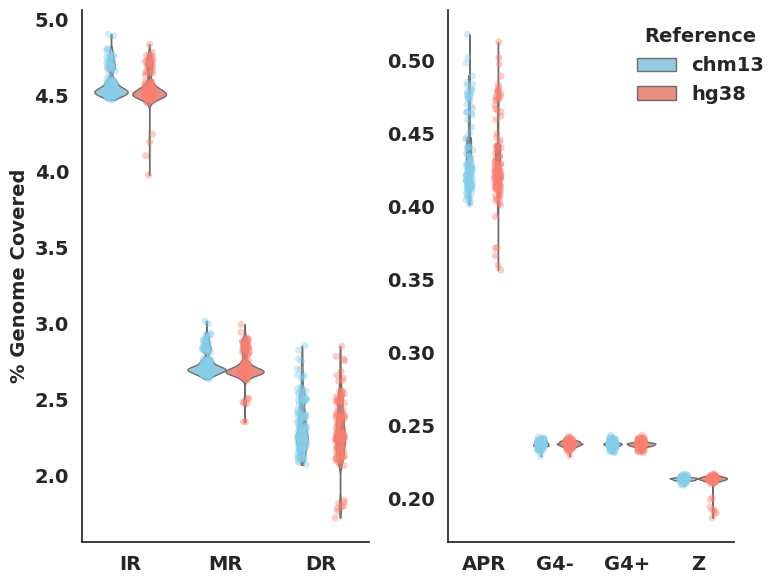

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set(style="white")

# === Load and process batches ===
def load_and_process_batches(chm13_paths, hg38_paths):
    def process(paths, reference, extra_path=None):
        dfs = [pd.read_csv(p) for p in paths]
        df = pd.concat(dfs, ignore_index=True)
        df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)
        df = df[df['Sample_Haplotype'] != 'NA20355_hap1']
        df['Total Bases Covered (Mb)'] = df['Total Bases Covered'] / 1e6
        df['Reference'] = reference
        if extra_path:
            extra = pd.read_csv(extra_path)
            extra[['Sample', 'Haplotype']] = extra['Sample_Haplotype'].str.split('_', expand=True)
            extra['Total Bases Covered (Mb)'] = extra['Total Bases Covered'] / 1e6
            extra['Reference'] = reference
            df = pd.concat([df, extra], ignore_index=True)
        return df

    chm13 = process(chm13_paths, 'chm13', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')
    hg38 = process(hg38_paths, 'hg38', '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch123_hg38_collapsed_quadron_summary_metrics_combined.csv')
    return chm13, hg38

# === Define input paths ===
chm13_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv'
]

hg38_paths = [
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch1_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch2_hg38_collapsed_summary_metrics.csv',
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/hg38_Q19_filtered/verkko_batch3_hg38_collapsed_summary_metrics.csv'
]

# === Load and merge
chm13_df, hg38_df = load_and_process_batches(chm13_paths, hg38_paths)
combined_df = pd.concat([chm13_df, hg38_df], ignore_index=True)

# Remove Z-DNA rows with 0 coverage
combined_df = combined_df[~((combined_df['Motif Type'] == 'Z') & (combined_df['Percent of Genome'] == 0))]

# Rename G4 types
combined_df['Motif Type'] = combined_df['Motif Type'].replace({
    'Positive_G_Quad': 'G4+',
    'Negative_G_Quad': 'G4-'
})

# === Clean categories
reference_palette = {'chm13': 'skyblue', 'hg38': 'salmon'}
group1_motifs = ['IR', 'MR', 'DR']
group2_motifs = sorted(set(combined_df['Motif Type']) - set(group1_motifs))

# Assign group column
combined_df['Group'] = combined_df['Motif Type'].apply(lambda x: 'IR/MR/DR' if x in group1_motifs else 'Other')

# Determine plotting order
group1_df = combined_df[combined_df['Group'] == 'IR/MR/DR']
group2_df = combined_df[combined_df['Group'] == 'Other']
group1_order = group1_df.groupby('Motif Type')['Percent of Genome'].median().sort_values(ascending=False).index.tolist()
group2_order = group2_df.groupby('Motif Type')['Percent of Genome'].median().sort_values(ascending=False).index.tolist()

# Apply ordered category
combined_df['Motif Type'] = pd.Categorical(
    combined_df['Motif Type'],
    categories=group1_order + group2_order,
    ordered=True
)

# === Compute and print median % Genome Covered per motif × reference ===
median_vals = (
    combined_df
    .groupby(["Motif Type", "Reference"], observed=True)["Percent of Genome"]
    .median()
    .reset_index()
    .sort_values(["Motif Type", "Reference"])
)

print("\nMedian % Genome Covered by Motif Type and Reference:\n")
print(median_vals.to_string(index=False))

# === Final Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharey=False)

for ax, group_label, motif_order, title in zip(
    axes,
    ['IR/MR/DR', 'Other'],
    [group1_order, group2_order],
    ['% Genome Covered (IR, MR, DR)', '% Genome Covered (G4, Z, APR)']
):
    group_df = combined_df[combined_df['Group'] == group_label]

    sns.violinplot(
        data=group_df,
        x='Motif Type',
        y='Percent of Genome',
        hue='Reference',
        palette=reference_palette,
        order=motif_order,
        dodge=True,
        cut=0,
        bw=0.2,
        ax=ax,
        linewidth=1
    )
    sns.stripplot(
        data=group_df,
        x='Motif Type',
        y='Percent of Genome',
        hue='Reference',
        palette=reference_palette,
        order=motif_order,
        dodge=True,
        jitter=True,
        alpha=0.4,
        ax=ax,
        legend=False
    )

    ax.set_xlabel('', fontsize=11, fontweight='bold')
    ax.set_ylabel('% Genome Covered' if ax == axes[0] else '', fontsize=14, fontweight='bold')
    #ax.set_title(title, fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=0, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    # Bold tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(14)

    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(14)
    ax.grid(False)
    sns.despine(ax=ax)

    if ax == axes[1]:
        leg = ax.legend(
            title='Reference',
            loc='upper left',
            bbox_to_anchor=(0.6, 1),
            fontsize=14,
            title_fontsize=14,
            frameon=False
        )
    # Bold everything
        leg.get_title().set_fontweight('bold')
        for text in leg.get_texts():
            text.set_fontweight('bold')
    else:
        ax.get_legend().remove()


plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/side_by_side_violin_split.pdf", dpi=300)
plt.show()

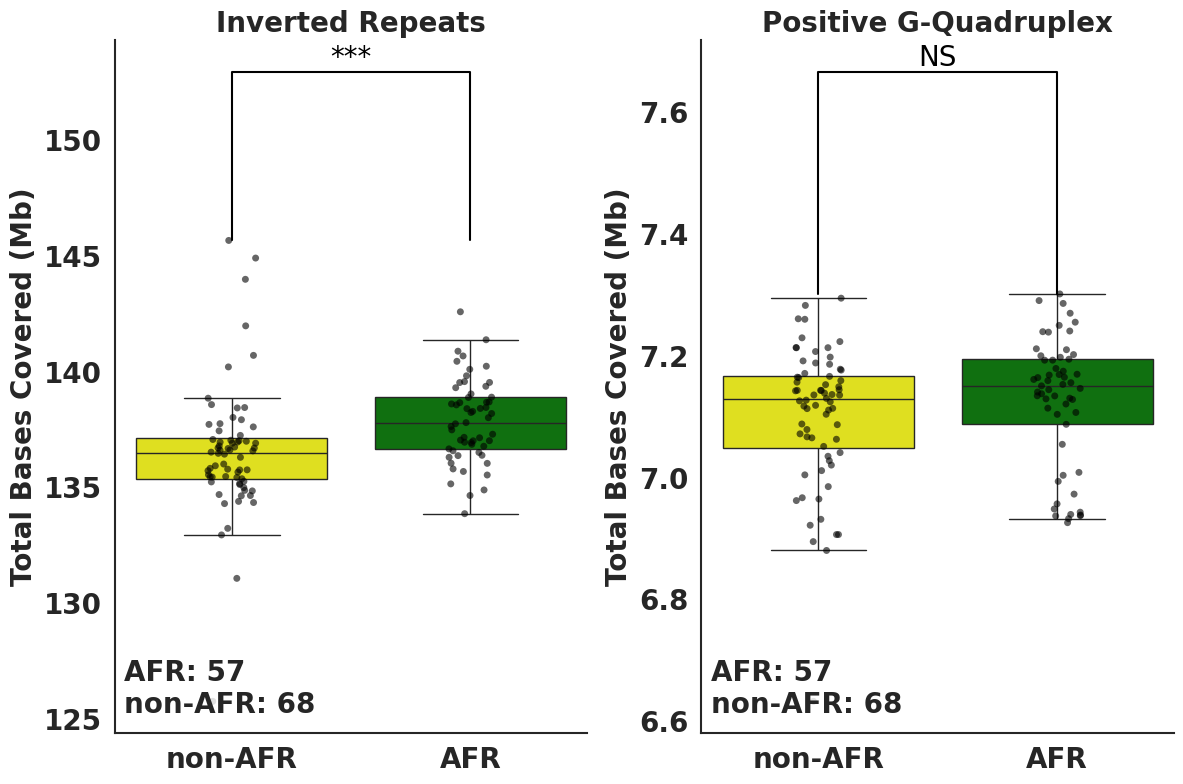

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Load your feature counts dataframes
batch1 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch1_chm13_collapsed_summary_metrics.csv')
batch2 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch2_chm13_collapsed_summary_metrics.csv')
batch3 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch3_chm13_collapsed_summary_metrics.csv')
batch4 = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/chm13_Q19_filtered/verkko_batch123_chm13_collapsed_quadron_summary_metrics_combined.csv')

df = pd.concat([batch1, batch2, batch3, batch4], ignore_index=True)
df[['Sample', 'Haplotype']] = df['Sample_Haplotype'].str.split('_', expand=True)

values_to_exclude = ['NA20355_hap1', 'NA21487_hap1', 'NA21487_hap2', 'NA24385_hap1', 'NA24385_hap2']
df = df[~df['Sample_Haplotype'].isin(values_to_exclude)]
sorted_df = df.sort_values(by='Sample_Haplotype')

metadata_df = pd.read_csv('/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/igsr_samples.tsv', delimiter='\t')
merged_df = pd.merge(sorted_df, metadata_df[['Sample name', 'Sex', 'Superpopulation name', 'Superpopulation code']], 
                     left_on='Sample', right_on='Sample name', how='left')

merged_df['Population Group'] = merged_df['Superpopulation code'].apply(lambda x: 'AFR' if x == 'AFR' else 'non-AFR')
merged_df['Total Bases Covered (Mb)'] = merged_df['Total Bases Covered'] / 1_000_000

palette = {'AFR': 'green', 'non-AFR': 'yellow'}
motif_name_map = {
    'DR': 'Direct Repeats',
    'MR': 'Mirror Repeats',
    'IR': 'Inverted Repeats',
    'APR': 'A-Phased Repeats',
    'Z': 'Z-DNA',
    'Positive_G_Quad': 'Positive G-Quadruplex',
    'Negative_G_Quad': 'Negative G-Quadruplex'
}

def add_significance_annotation(ax, p_value, x1, x2, y, h, col):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    if p_value < 0.001:
        significance_text = '***'
    elif p_value < 0.01:
        significance_text = '**'
    elif p_value < 0.05:
        significance_text = '*'
    else:
        significance_text = 'NS'
    ax.text((x1 + x2) * .5, y + h, significance_text, ha='center', va='bottom', color=col, fontsize=20)

# === OPTIONAL: filter motifs here ===
motif_types = ['IR', 'Positive_G_Quad']  # <-- Only these two motifs will be plotted
# motif_types = merged_df['Motif Type'].unique()  # <-- Uncomment this to do all motifs

num_motifs = len(motif_types)
fig, axes = plt.subplots(nrows=num_motifs // 2 + num_motifs % 2, ncols=2, figsize=(12, num_motifs * 4))
axes = axes.flatten()

for idx, motif in enumerate(motif_types):
    motif_df = merged_df[merged_df['Motif Type'] == motif]

    ax = sns.boxplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', 
                     hue='Population Group', palette=palette, dodge=False, showfliers=False, ax=axes[idx])
    
    sns.stripplot(data=motif_df, x='Population Group', y='Total Bases Covered (Mb)', 
                  hue='Population Group', palette=['black']*2, dodge=False, jitter=True, size=5, marker='o', alpha=0.6, ax=ax)

    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel('Total Bases Covered (Mb)', fontsize=20, fontweight='bold')
    ax.set_title(f'{motif_name_map.get(motif, motif)}', fontsize=20, weight='bold')
    ax.tick_params(labelsize=12)
    # Bold tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(20)

    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(20)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(False)  # Remove gridlines
    ax.legend([], [], frameon=False)

    afr_data = motif_df[motif_df['Population Group'] == 'AFR']['Total Bases Covered (Mb)']
    non_afr_data = motif_df[motif_df['Population Group'] == 'non-AFR']['Total Bases Covered (Mb)']
    _, p_value_total_bases = mannwhitneyu(afr_data, non_afr_data)

    y_max = motif_df['Total Bases Covered (Mb)'].max()
    add_significance_annotation(ax, p_value_total_bases, 0, 1, y_max, 0.05 * y_max, 'black')

    afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'AFR']['Sample_Haplotype'].nunique()
    non_afr_sample_haplotypes = motif_df[motif_df['Population Group'] == 'non-AFR']['Sample_Haplotype'].nunique()
    
    ax.text(0.02, 0.02,
        f"AFR: {afr_sample_haplotypes}\nnon-AFR: {non_afr_sample_haplotypes}",
        transform=ax.transAxes,   # <-- use axes coords
        ha='left',                # <-- anchor left
        va='bottom',              # <-- anchor bottom
        fontsize=20,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
        fontweight='bold')


plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/AFR_NONAFR_base_coverage_whole_genome_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Figure 2 - IR and G4 Sequence Stability and cCRE enrichment

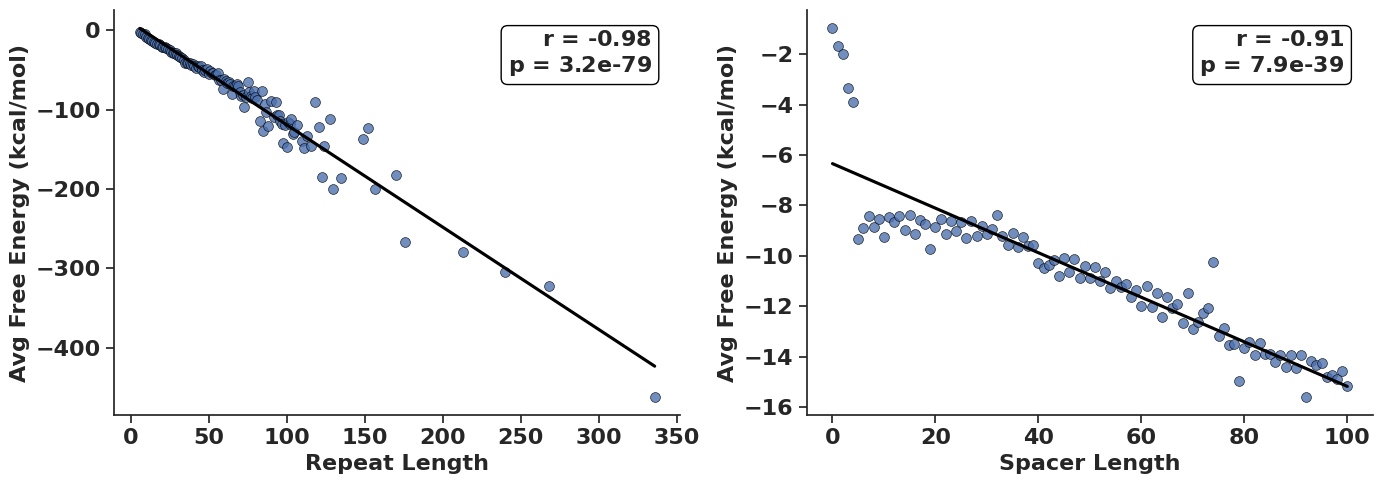

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load and prepare data
file_path = "/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap2_IR_free_energy.tsv"
df = pd.read_csv(file_path, sep="\t").drop(columns=["Sequence"])

df['Repeat'] = pd.to_numeric(df['Repeat'], errors='coerce')
df['Spacer'] = pd.to_numeric(df['Spacer'], errors='coerce')
df['Free_Energy'] = pd.to_numeric(df['Free_Energy'], errors='coerce')
df = df.dropna(subset=['Repeat', 'Spacer', 'Free_Energy'])

# Group and average
repeat_means = df.groupby('Repeat')['Free_Energy'].mean().reset_index()
spacer_means = df.groupby('Spacer')['Free_Energy'].mean().reset_index()

# Correlation
corr_repeat = stats.pearsonr(repeat_means['Repeat'], repeat_means['Free_Energy'])
corr_spacer = stats.pearsonr(spacer_means['Spacer'], spacer_means['Free_Energy'])

# Plot aesthetics
sns.set(style="ticks")  # no gridlines
plt.figure(figsize=(14, 5))

# Shared settings
marker_style = dict(s=50, edgecolor='black', linewidths=0.5)

# Repeat vs Free Energy
ax1 = plt.subplot(1, 2, 1)
sns.regplot(data=repeat_means, x='Repeat', y='Free_Energy',
            scatter_kws=marker_style, line_kws={"color": "black"}, ci=None)
#ax1.set_title("Avg Free Energy vs Repeat Length", fontsize=14, fontweight="bold")
ax1.set_xlabel("Repeat Length", fontsize=16, fontweight='bold')
ax1.set_ylabel("Avg Free Energy (kcal/mol)", fontsize=16, fontweight='bold')
sns.despine(ax=ax1)

# Add boxed stats
ax1.text(0.95, 0.95,
         f"$\mathbf{{r}}$ = {corr_repeat[0]:.2f}\n$\mathbf{{p}}$ = {corr_repeat[1]:.2g}",
         transform=ax1.transAxes, ha='right', va='top', fontsize=16, fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Spacer vs Free Energy
ax2 = plt.subplot(1, 2, 2)
sns.regplot(data=spacer_means, x='Spacer', y='Free_Energy',
            scatter_kws=marker_style, line_kws={"color": "black"}, ci=None)
#ax2.set_title("Avg Free Energy vs Spacer Length", fontsize=14, fontweight="bold")
ax2.set_xlabel("Spacer Length", fontsize=16, fontweight='bold')
ax2.set_ylabel("Avg Free Energy (kcal/mol)", fontsize=16, fontweight='bold')
sns.despine(ax=ax2)

# Add boxed stats
ax2.text(0.95, 0.95,
         f"$\mathbf{{r}}$ = {corr_spacer[0]:.2f}\n$\mathbf{{p}}$ = {corr_spacer[1]:.2g}",
         transform=ax2.transAxes, ha='right', va='top', fontsize=16, fontweight='bold',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Bold tick labels
for tick in ax1.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax1.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# Bold tick labels
for tick in ax2.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax2.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/free_energy_vs_irs.pdf', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_3640547/3011412007.py:122: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


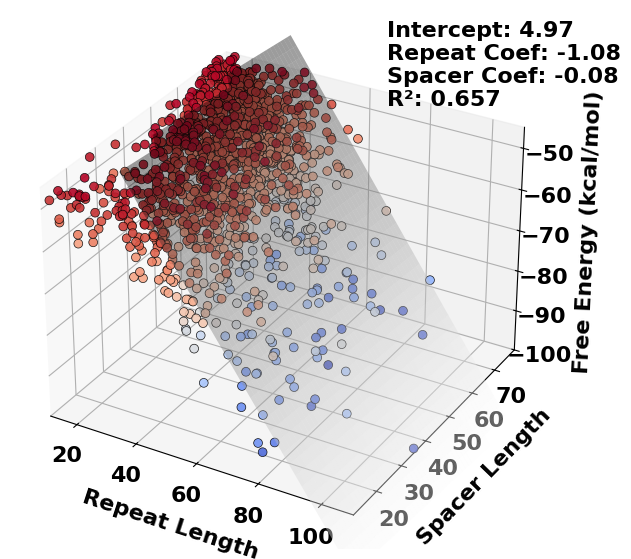

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D

# === Load and clean data
file_path = "/home/alextu/scratch/free_energy_IRs_verkko_123_wholegenome_hg38/HG00096_hap2_IR_free_energy.tsv"
df = pd.read_csv(file_path, sep="\t").drop(columns=["Sequence"])

df['Repeat'] = pd.to_numeric(df['Repeat'], errors='coerce')
df['Spacer'] = pd.to_numeric(df['Spacer'], errors='coerce')
df['Free_Energy'] = pd.to_numeric(df['Free_Energy'], errors='coerce')
df = df.dropna(subset=['Repeat', 'Spacer', 'Free_Energy'])

# === Train linear model on full data
X = sm.add_constant(df[['Repeat', 'Spacer']])
y = df['Free_Energy']
model = sm.OLS(y, X).fit()

# === Filter data for plotting only
plot_df = df[
    (df['Repeat'] > 10) & (df['Repeat'] < 200) &
    (df['Spacer'] > 10) & (df['Spacer'] < 80) &
    (df['Free_Energy'] < -45) & (df['Free_Energy'] > -100)
]

# === Group by Repeat + Spacer and compute mean Free Energy
df_grouped = (
    plot_df.groupby(['Repeat', 'Spacer'])['Free_Energy']
    .mean()
    .reset_index()
    .rename(columns={'Free_Energy': 'Mean_Free_Energy'})
)

capped_energy = np.clip(df_grouped['Mean_Free_Energy'], -100, 0)

# === Create meshgrid for regression surface (only in filtered range)
# Shrink surface dimensions for a cleaner fit
# Dynamically detect point boundaries, with optional padding
repeat_min = df_grouped['Repeat'].min()
repeat_max = df_grouped['Repeat'].max()
spacer_min = df_grouped['Spacer'].min()
spacer_max = df_grouped['Spacer'].max()

# Optional: trim off grey slab by tightening the range slightly
repeat_range = np.linspace(repeat_min, repeat_max, 50)
spacer_range = np.linspace(spacer_min, spacer_max, 50)
R, S = np.meshgrid(repeat_range, spacer_range)

grid_df = pd.DataFrame({'Repeat': R.ravel(), 'Spacer': S.ravel()})
grid_df_const = sm.add_constant(grid_df)
Z = model.predict(grid_df_const).values.reshape(R.shape)

# Mask values above -45 so they're not rendered
Z = np.where(Z > -35, np.nan, Z)

# === Plot
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

# Regression surface (flat plane)
surf = ax.plot_surface(
    R, S, Z,
    cmap='Greys',
    alpha=0.4,
    edgecolor='none',
    antialiased=True
)

# Scatter of grouped mean values
obs = ax.scatter(
    df_grouped['Repeat'],
    df_grouped['Spacer'],
    df_grouped['Mean_Free_Energy'],
    c=capped_energy,
    cmap='coolwarm',
    s=40,
    edgecolors='black',
    linewidth=0.5,
    alpha=0.9
)

# Axis labels and title
ax.set_xlabel("Repeat Length", labelpad=10, fontweight='bold', fontsize = 16)
ax.set_ylabel("Spacer Length", labelpad=10, fontweight='bold', fontsize = 16)
ax.set_zlabel("Free Energy (kcal/mol)", labelpad=10, fontweight='bold', fontsize = 16)
#ax.set_title("OLS Regression Surface", pad=20)

# Axis limits (zoom)
ax.set_xlim(df_grouped['Repeat'].min(), df_grouped['Repeat'].max())
ax.set_ylim(df_grouped['Spacer'].min(), df_grouped['Spacer'].max())
ax.set_zlim(-100, -45)

for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_zticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# Colorbar
#cb = fig.colorbar(obs, ax=ax, shrink=0.6, pad=0.1)
#cb.set_label("Free Energy", rotation=270, labelpad=15, fontweigh)

# Stats annotation from full model — move to right
coef_text = (
    f"Intercept: {model.params['const']:.2f}\n"
    f"Repeat Coef: {model.params['Repeat']:.2f}\n"
    f"Spacer Coef: {model.params['Spacer']:.2f}\n"
    f"R²: {model.rsquared:.3f}"
)
ax.text2D(0.70, 0.98, coef_text, transform=ax.transAxes,
          fontsize=16, verticalalignment='top', fontweight='bold')
          #bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="black", alpha=0.5))

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/free_energy_vs_irs_OLS.pdf', bbox_inches='tight', dpi=300)
plt.show()

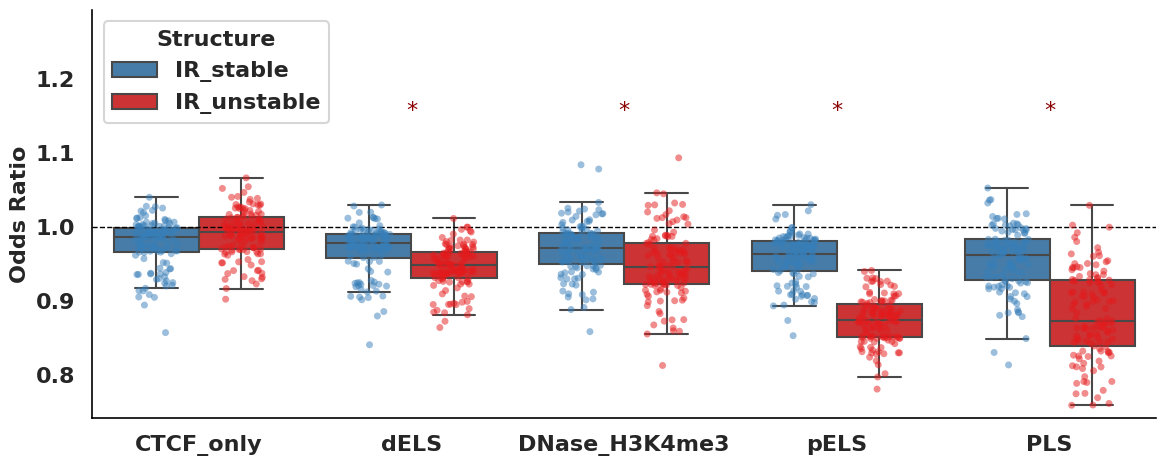

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import mannwhitneyu
import numpy as np

# === Set seaborn style for publication ===
sns.set_context("talk")  # larger fonts
sns.set_style("white")   # no gridlines
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

# === Directory containing IR odds ratio result files ===
data_dir = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/cCRE_analysis/results_IRs_free_energy/"
files = glob.glob(os.path.join(data_dir, "final_results_IR_stable_vs_unstable_*.csv"))

# === Extract cCRE type from filename ===
def get_ccre_type(filename):
    base = os.path.basename(filename)
    return base.replace("final_results_IR_stable_vs_unstable_", "").replace(".csv", "")

# === Load and combine ===
dfs = []
for f in files:
    df = pd.read_csv(f)
    df['ccre'] = get_ccre_type(f)
    dfs.append(df)
combined = pd.concat(dfs)

# === Pivot and melt for plotting ===
pivoted = combined.pivot_table(index=['sample_hap', 'ccre'], columns='structure', values='odds_ratio').reset_index()
melted = pd.melt(pivoted, id_vars=['sample_hap', 'ccre'], value_vars=['IR_stable', 'IR_unstable'],
                 var_name='structure', value_name='odds_ratio')

# === Sort cCREs by IR_stable median ===
order = (
    melted[melted['structure'] == 'IR_stable']
    .groupby('ccre')['odds_ratio']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# === Mann–Whitney U tests ===
raw_pvals = []
tested_ccres = []

for ccre in order:
    group = melted[melted['ccre'] == ccre]
    stable = group[group['structure'] == 'IR_stable']['odds_ratio']
    unstable = group[group['structure'] == 'IR_unstable']['odds_ratio']
    if len(stable) > 1 and len(unstable) > 1:
        stat, p = mannwhitneyu(stable, unstable, alternative='two-sided')
    else:
        p = 1.0
    raw_pvals.append(p)
    tested_ccres.append(ccre)

# === Bonferroni correction ===
raw_pvals = np.array(raw_pvals)
bonferroni_pvals = np.clip(raw_pvals * len(raw_pvals), 0, 1)
pval_dict = dict(zip(tested_ccres, bonferroni_pvals))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 5))

# Custom publication-style color palette
custom_palette = {
    "IR_stable": "#377eb8",    # Blue
    "IR_unstable": "#e41a1c"   # Red
}

sns.boxplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
            palette=custom_palette, showfliers=False, order=order, ax=ax, linewidth=1.5)

sns.stripplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
              dodge=True, palette=custom_palette, alpha=0.5, size=5, jitter=0.2,
              order=order, ax=ax, legend=False)

# Reference line
ax.axhline(1, color='black', linestyle='--', linewidth=1)

# Axis labels and title
#ax.set_title("Odds Ratios of IR_stable vs IR_unstable across cCRE Elements", fontsize=16, weight='bold')
ax.set_ylabel("Odds Ratio", fontsize=16, fontweight='bold')
ax.set_xlabel("", fontsize=14)

# Rotate x-tick labels safely
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles=handles[:2],
    labels=labels[:2],
    title='Structure',
    title_fontsize=16,
    fontsize=16,
    loc='upper left'
)

# ---- Bold title + label text ----
leg.get_title().set_fontweight('bold')
for text in leg.get_texts():
    text.set_fontweight('bold')
    tick.set_fontsize(16)


# Add significance stars
y_max = melted['odds_ratio'].max()
for i, ccre in enumerate(order):
    if pval_dict.get(ccre, 1.0) < 0.01:
        ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='darkred')

ax.set_ylim(top=y_max + 0.2)
sns.despine()

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/IR_OR_stability_ccre.pdf', bbox_inches='tight', dpi=300)
plt.show()

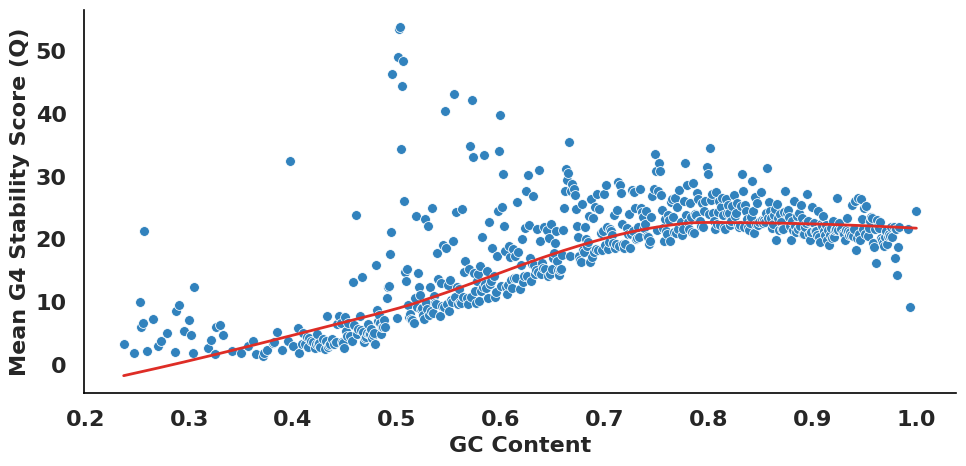

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Seaborn + Matplotlib publication settings
sns.set_context("talk")  # Larger fonts
sns.set_style("white")   # White background, no grid
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "bold"

# === Load data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_chm13_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === Compute GC content
df['G_count'] = df['Sequence'].str.count('G')
df['C_count'] = df['Sequence'].str.count('C')
df['GC_content'] = ((df['G_count'] + df['C_count']) / df['Sequence'].str.len()).round(3)

# === Filter for minus strand only
df_minus = df[df['STR'] == '+']

# === Group by GC content and average stability
gc_avg_minus = df_minus.groupby('GC_content')['Q'].mean().reset_index().dropna()

# === Plot
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(data=gc_avg_minus, x='GC_content', y='Q', color="#3182bd", s=50)
sns.regplot(data=gc_avg_minus, x='GC_content', y='Q', lowess=True,
            scatter=False, color="#de2d26", line_kws={"lw": 2})

#ax.set_title("G4 Stability vs GC Content", fontsize=16, weight='bold')
ax.set_xlabel("GC Content", fontsize=16)
ax.set_ylabel("Mean G4 Stability Score (Q)", fontsize=16)

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

ax.tick_params(labelsize=16)
sns.despine()

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/g4_stability_vs_gc_content.pdf', bbox_inches='tight', dpi=300)
plt.show()

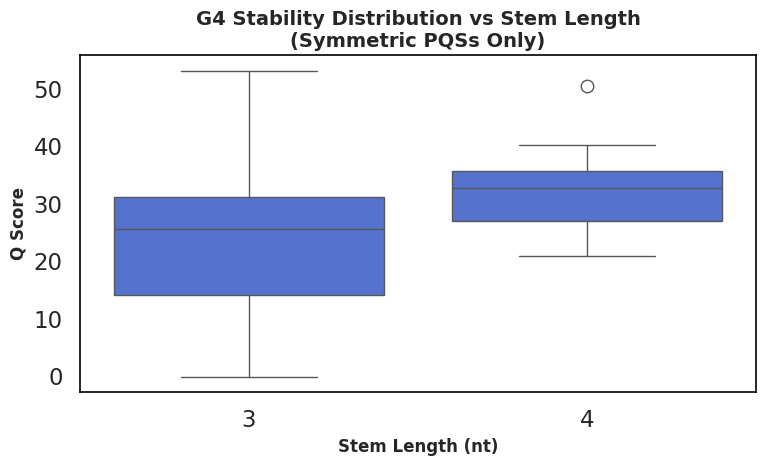

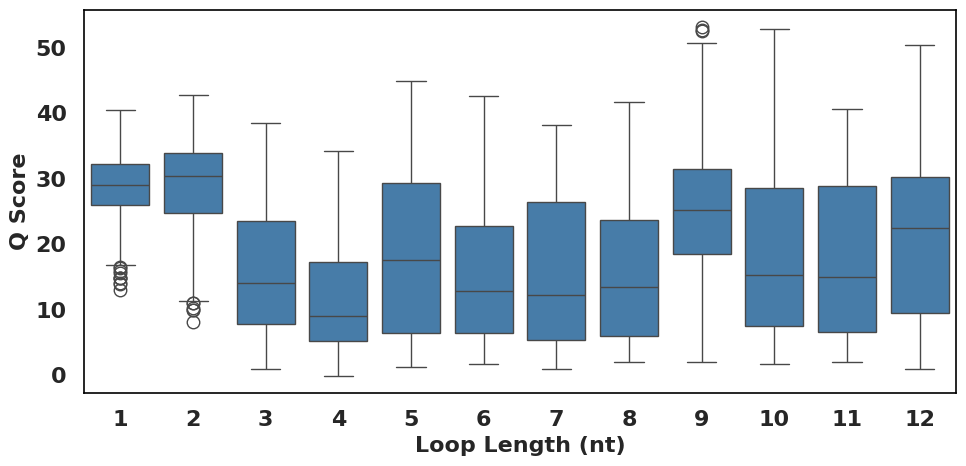

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import sem, pearsonr

# === Load Quadron data
df = pd.read_csv("/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/quadron_all_q_filtered_csvs/20230818_verkko_batch1_assemblies_aligned_chm13_collapsed/HG00171_hap1_quadron_filtered_verkko_batch1.csv")

# === PQS pattern (Quadron definition)
Lmax = 12
pattern = re.compile(
    fr'(G{{3,}})'               # Stem1
    fr'(.{{1,{Lmax}}})'         # Loop1
    fr'(G{{3,}})'               # Stem2
    fr'(.{{1,{Lmax}}})'         # Loop2
    fr'(G{{3,}})'               # Stem3
    fr'(.{{1,{Lmax}}})'         # Loop3
    fr'(G{{3,}})'               # Stem4
)

# === Extract only symmetric PQSs (equal stem + loop lengths)
def extract_if_uniform(seq):
    match = pattern.search(seq)
    if match:
        stems = [match.group(i) for i in [1, 3, 5, 7]]
        loops = [match.group(i) for i in [2, 4, 6]]
        stem_lens = list(map(len, stems))
        loop_lens = list(map(len, loops))
        if len(set(stem_lens)) == 1 and len(set(loop_lens)) == 1:
            return pd.Series({
                'Stem_Length': stem_lens[0],
                'Loop_Length': loop_lens[0]
            })
    return pd.Series({'Stem_Length': None, 'Loop_Length': None})

# === Apply extraction
features = df['Sequence'].apply(extract_if_uniform)
df_uniform = pd.concat([df, features], axis=1).dropna()

# === Optional: filter by count (keep only groups with ≥10 PQSs)
stem_counts = df_uniform['Stem_Length'].value_counts()
loop_counts = df_uniform['Loop_Length'].value_counts()
valid_stems = stem_counts[stem_counts >= 10].index
valid_loops = loop_counts[loop_counts >= 10].index

df_filtered = df_uniform[
    df_uniform['Stem_Length'].isin(valid_stems) &
    df_uniform['Loop_Length'].isin(valid_loops)
]

df_filtered['Stem_Length'] = df_filtered['Stem_Length'].astype(int)
df_filtered['Loop_Length'] = df_filtered['Loop_Length'].astype(int)

# === Boxplot: Q vs Stem Length
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_filtered, x='Stem_Length', y='Q', color='royalblue')
plt.title("G4 Stability Distribution vs Stem Length\n(Symmetric PQSs Only)", fontsize=14, weight='bold')
plt.xlabel("Stem Length (nt)", fontsize=12)
plt.ylabel("Q Score", fontsize=12)
plt.tight_layout()
plt.show()

# === Boxplot: Q vs Loop Length
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_filtered, x='Loop_Length', y='Q', color='#377eb8')
#plt.title("G4 Stability vs Loop Length", fontsize=14, weight='bold')
plt.xlabel("Loop Length (nt)", fontsize=16, fontweight='bold')
plt.ylabel("Q Score", fontsize=16, fontweight='bold')
# Bold tick labels
plt.xticks(fontweight='bold', fontsize=16)
plt.yticks(fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/G4_loop_stability.pdf', bbox_inches='tight', dpi=300)
plt.show()

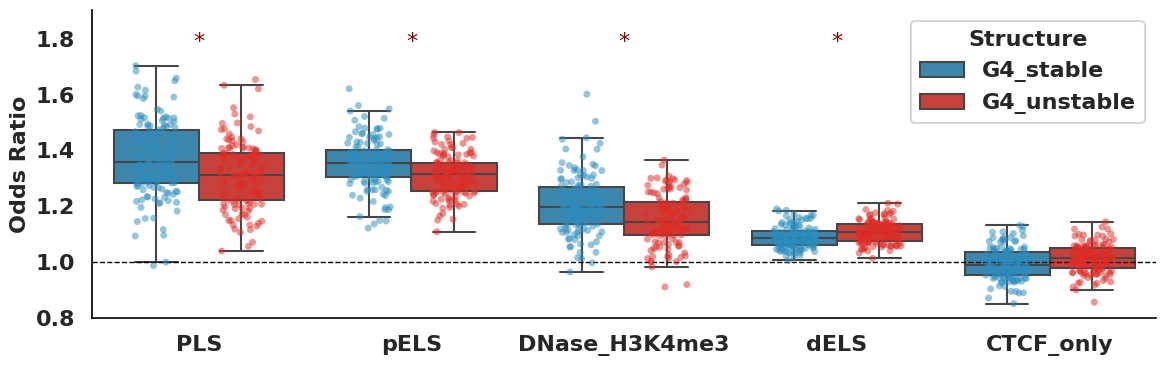

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import mannwhitneyu
import numpy as np

# === Set custom style for publication ===
sns.set_context("talk")  # larger font sizes
sns.set_style("white")   # white background, no grid
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

# === Directory where your files are stored ===
data_dir = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/cCRE_analysis/results_wholegenome_allQs/"
files = glob.glob(os.path.join(data_dir, "final_results_G4_stable_vs_unstable_*.csv"))

# === Extract cCRE type from filename ===
def get_ccre_type(filename):
    base = os.path.basename(filename)
    return base.replace("final_results_G4_stable_vs_unstable_", "").replace(".csv", "")

# === Load and combine ===
dfs = []
for f in files:
    df = pd.read_csv(f)
    df['ccre'] = get_ccre_type(f)
    dfs.append(df)
combined = pd.concat(dfs)

# === Pivot and melt ===
pivoted = combined.pivot_table(index=['sample_hap', 'ccre'], columns='structure', values='odds_ratio').reset_index()
melted = pd.melt(pivoted, id_vars=['sample_hap', 'ccre'], value_vars=['G4_stable', 'G4_unstable'],
                 var_name='structure', value_name='odds_ratio')

# === Sort cCREs by G4_stable median ===
order = (
    melted[melted['structure'] == 'G4_stable']
    .groupby('ccre')['odds_ratio']
    .median()
    .sort_values(ascending=False)
    .index.tolist()
)

# === Mann-Whitney U testing ===
raw_pvals = []
tested_ccres = []
for ccre in order:
    group = melted[melted['ccre'] == ccre]
    stable = group[group['structure'] == 'G4_stable']['odds_ratio']
    unstable = group[group['structure'] == 'G4_unstable']['odds_ratio']
    if len(stable) > 1 and len(unstable) > 1:
        stat, p = mannwhitneyu(stable, unstable, alternative='two-sided')
    else:
        p = 1.0
    raw_pvals.append(p)
    tested_ccres.append(ccre)

# === Bonferroni correction ===
raw_pvals = np.array(raw_pvals)
bonferroni_pvals = np.clip(raw_pvals * len(raw_pvals), 0, 1)
pval_dict = dict(zip(tested_ccres, bonferroni_pvals))

# === Plot ===
fig, ax = plt.subplots(figsize=(12, 4))

# Custom, elegant colors
custom_palette = {
    "G4_stable": "#2b8cbe",    # Blue
    "G4_unstable": "#de2d26"   # Red
}

sns.boxplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
            palette=custom_palette, showfliers=False, order=order, ax=ax, linewidth=1.5)

sns.stripplot(data=melted, x='ccre', y='odds_ratio', hue='structure',
              dodge=True, palette=custom_palette, alpha=0.5, size=5, jitter=0.2,
              order=order, ax=ax, legend=False)

# Reference line
ax.axhline(1, color='black', linestyle='--', linewidth=1)

# Axis labels and title
#ax.set_title("Odds Ratios of Stable vs Unstable G4s across cCRE Elements", fontsize=16, weight='bold')
ax.set_ylabel("Odds Ratio", fontsize=16, fontweight='bold')
ax.set_xlabel("", fontsize=16)
ax.set_yticks(ax.get_yticks())
ax.tick_params(axis='y', labelsize=16)
# Clean up x-axis ticks
ax.tick_params(axis='x', labelrotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=16)
# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles=handles[:2],
    labels=labels[:2],
    title='Structure',
    title_fontsize=16,
    fontsize=16,
    loc='upper right'
)

# ---- Bold title + label text ----
leg.get_title().set_fontweight('bold')
for text in leg.get_texts():
    text.set_fontweight('bold')


# Add significance markers
y_max = melted['odds_ratio'].max()
for i, ccre in enumerate(order):
    if pval_dict.get(ccre, 1.0) < 0.01:
        ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='darkred')

ax.set_ylim(top=y_max + 0.2)
sns.despine()

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/G4_OR_stability_ccre.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Figure 3 - Non-B DNA and Centromeres

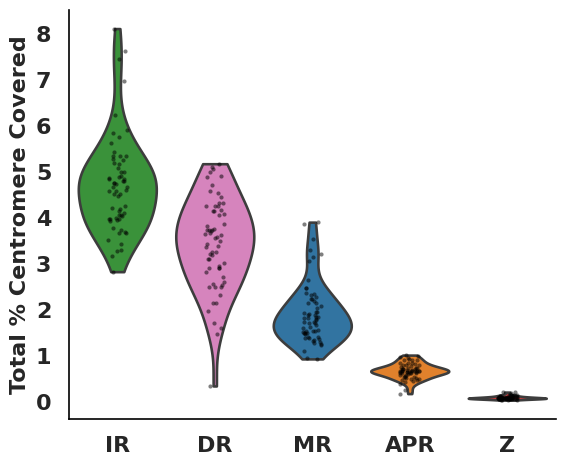

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# === Load motif BED summaries ===
nonb_files = sorted(glob.glob(
    '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/centromere_summary_stats/haplotype_summarystats_verkko123/verkko123_collapsed_summary_metrics_centromere_chr*.csv'))

nonb_data = []
for file in nonb_files:
    df = pd.read_csv(file)
    chromosome = os.path.basename(file).split('_')[-1].replace('.csv', '')
    df['Chromosome'] = chromosome
    df['Sample'] = df['Sample_Haplotype_Chromosome'].str.extract(r'(HG\d{5}|NA\d{5})')[0]
    nonb_data.append(df)

nonb_df = pd.concat(nonb_data, ignore_index=True)

# === Load centromere lengths ===
centromere_bed_path = '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/centromere_summary_stats/haplotype_summarystats_verkko123/hgsvc3_verkko_v1.4_nonredundant_complete_and_accurate_centromeric_regions_v3.bed'
centromere_columns = ['Haplotype', 'Start', 'End', 'Sample', 'Chromosome']
centromere_df = pd.read_csv(centromere_bed_path, sep='\t', header=None, names=centromere_columns)
centromere_df['Centromere_Length'] = centromere_df['End'] - centromere_df['Start']

# === Merge lengths ===
nonb_df = pd.merge(nonb_df, centromere_df[['Sample', 'Chromosome', 'Centromere_Length']],
                   on=['Sample', 'Chromosome'], how='left')

# === Summarize by sample and motif ===
grouped_df = nonb_df.groupby(['Sample', 'Motif Type'], observed=False).agg({
    'Total Bases Covered': 'sum',
    'Centromere_Length': 'sum'
}).reset_index()

grouped_df['Percent_Centromere_Covered'] = (
    grouped_df['Total Bases Covered'] / grouped_df['Centromere_Length']) * 100

# === Explicit motif color palette ===
motif_palette = {
    "IR": "#2ca02c",     # Green
    "DR": "#e377c2",     # Pink
    "MR": "#1f77b4",     # Blue
    "APR": "#ff7f0e",    # Orange
    "Z": "#d62728",      # Red
}

# Filter & order motifs by presence and color order
motif_order = [m for m in motif_palette if m in grouped_df["Motif Type"].unique()]

# === Plot aesthetics ===
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["axes.labelweight"] = "bold"

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 5))

sns.violinplot(
    data=grouped_df,
    x='Motif Type',
    y='Percent_Centromere_Covered',
    hue='Motif Type',
    palette=motif_palette,
    order=motif_order,
    cut=0,
    inner=None,
    legend=False,
    ax=ax
)

sns.stripplot(
    data=grouped_df,
    x='Motif Type',
    y='Percent_Centromere_Covered',
    order=motif_order,
    color='black',
    size=3,
    alpha=0.5,
    jitter=True,
    ax=ax
)

# Labels and title
#ax.set_title("Centromeric Coverage by Non-B Motif", fontsize=16, weight='bold')
ax.set_ylabel("Total % Centromere Covered", fontsize=16, fontweight = 'bold')
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

sns.despine()
plt.tight_layout()

# === Save ===
output_path = '/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/verkko123_centromeres_violinplot_by_motif_PER_SAMPLE_sorted_median.pdf'
plt.savefig(output_path, dpi=300)
plt.show()

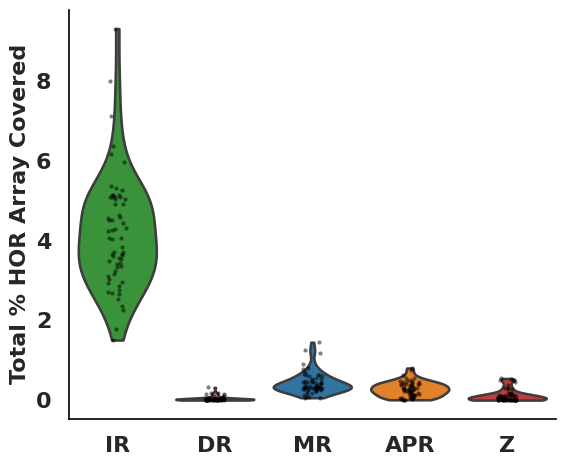

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# === Paths ===
base_path = '/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/results/summary_stats/centromere_summary_stats/haplotype_summarystats_verkko123_active_asat_HOR_arrays/'

# === Load motif BED summaries ===
nonb_files = sorted(glob.glob(base_path + 'verkko123_collapsed_summary_metrics_centromere_chr*.csv'))
nonb_data = []

for file in nonb_files:
    df = pd.read_csv(file)
    chromosome = os.path.basename(file).split('_')[-1].replace('.csv', '')
    df['Chromosome'] = chromosome
    df['Sample'] = df['Sample_Haplotype_Chromosome'].str.extract(r'(HG\d{5}|NA\d{5})')[0]
    nonb_data.append(df)

nonb_df = pd.concat(nonb_data, ignore_index=True)

# === Load HOR array lengths ===
asat_bed_path = base_path + 'hgsvc3_verkko_v1.4_nonredundant_complete_and_accurate_active_asat_HOR_arrays_v3.bed'
asat_columns = ['Haplotype', 'Start', 'End', 'Sample', 'Chromosome']
asat_df = pd.read_csv(asat_bed_path, sep='\t', header=None, names=asat_columns)
asat_df['HOR_Length'] = asat_df['End'] - asat_df['Start']

# === Merge ===
nonb_df = pd.merge(nonb_df, asat_df[['Sample', 'Chromosome', 'HOR_Length']],
                   on=['Sample', 'Chromosome'], how='left')

# === Group by sample and motif ===
grouped_df = nonb_df.groupby(['Sample', 'Motif Type'], observed=False).agg({
    'Total Bases Covered': 'sum',
    'HOR_Length': 'sum'
}).reset_index()

grouped_df['Percent_HOR_Covered'] = (
    grouped_df['Total Bases Covered'] / grouped_df['HOR_Length']) * 100

# === Explicit motif color palette (same as centromere plot) ===
motif_palette = {
    "IR": "#2ca02c",     # Green
    "DR": "#e377c2",     # Pink
    "MR": "#1f77b4",     # Blue
    "APR": "#ff7f0e",    # Orange
    "Z": "#d62728",      # Red
}

# Filter & order motifs by presence and defined color order
motif_order = [m for m in motif_palette if m in grouped_df["Motif Type"].unique()]

# === Plot aesthetics ===
sns.set_context("talk")
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"
plt.rcParams["axes.labelweight"] = "bold"

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 5))

sns.violinplot(
    data=grouped_df,
    x='Motif Type',
    y='Percent_HOR_Covered',
    hue='Motif Type',
    palette=motif_palette,
    order=motif_order,
    cut=0,
    inner=None,
    legend=False,
    ax=ax
)

sns.stripplot(
    data=grouped_df,
    x='Motif Type',
    y='Percent_HOR_Covered',
    order=motif_order,
    color='black',
    size=3,
    alpha=0.5,
    jitter=True,
    ax=ax
)

# Labels and formatting
#ax.set_title("Active ASAT array Coverage by Non-B Motif", fontsize=16, weight='bold')
ax.set_ylabel("Total % HOR Array Covered", fontsize=16, fontweight='bold')
ax.set_xlabel("", fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# Clean up
sns.despine()
plt.tight_layout()

# === Save ===
output_path = '/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/verkko123_asat_arrays_violinplot_by_motif_PER_SAMPLE_sorted_median.pdf'
plt.savefig(output_path, dpi=300)
plt.show()

# Figure 4 - Non-B DNA and Fixed Segmental Duplications

/tmp/ipykernel_4146528/1274376305.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_no_outliers = df.groupby("structure", group_keys=False).apply(remove_outliers)
/tmp/ipykernel_4146528/1274376305.py:64: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


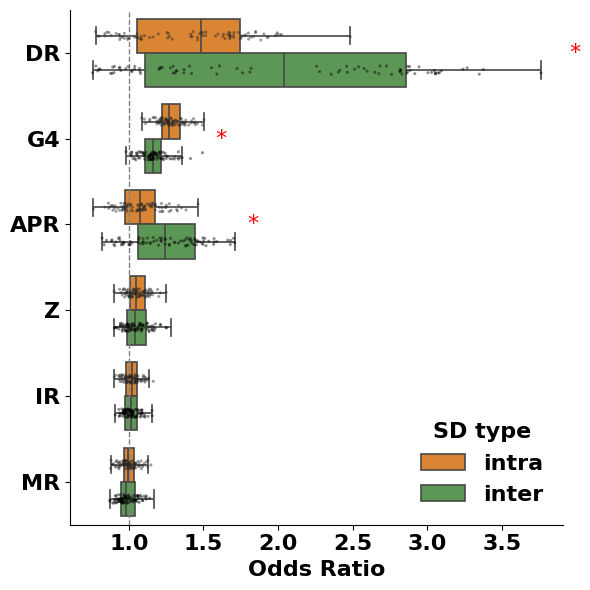

[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/overall_nonB_segdup_enrichment_GROUPED_bySD_flipped_sig.pdf


In [21]:
#!/usr/bin/env python3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ====== CONFIG ======
IN_CSV  = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/segdup_analysis/fixed_SDs/final_results_SegDup_FIXED.csv"
OUT_PDF = "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/overall_nonB_segdup_enrichment_GROUPED_bySD_flipped_sig.pdf"

ORDER_SDTYPE = ["intra", "inter"]
HUE_PALETTE  = {"intra": "#F58518", "inter": "#54A24B"}

# ====== LOAD ======
df = pd.read_csv(IN_CSV)
wanted = {"G4", "MR", "DR", "IR", "APR", "Z"}

if not {"structure", "odds_ratio", "sd_type"} <= set(df.columns):
    raise ValueError("CSV must have columns: structure, odds_ratio, sd_type")

df = df.dropna(subset=["structure", "odds_ratio", "sd_type"])
df = df[(df["odds_ratio"] > 0) & df["structure"].isin(wanted)]
df = df[df["sd_type"].isin(ORDER_SDTYPE)].copy()
df["sd_type"] = pd.Categorical(df["sd_type"], categories=ORDER_SDTYPE, ordered=True)

median_order = (
    df.groupby("structure")["odds_ratio"]
      .median()
      .sort_values(ascending=False)
      .index.tolist()
)

# ====== SIGNIFICANCE TESTS ======
pvals = {}
for struct in median_order:
    sub = df[df["structure"] == struct]
    intra = sub.loc[sub["sd_type"] == "intra", "odds_ratio"]
    inter = sub.loc[sub["sd_type"] == "inter", "odds_ratio"]
    if len(intra) > 2 and len(inter) > 2:
        stat, p = mannwhitneyu(intra, inter, alternative="two-sided")
        pvals[struct] = p
    else:
        pvals[struct] = None


def remove_outliers(group):
    q1 = group["odds_ratio"].quantile(0.25)
    q3 = group["odds_ratio"].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group["odds_ratio"] >= lower) & (group["odds_ratio"] <= upper)]

df_no_outliers = df.groupby("structure", group_keys=False).apply(remove_outliers)

# ====== PLOT ======
plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    data=df, y="structure", x="odds_ratio",
    order=median_order, hue="sd_type",
    palette=HUE_PALETTE, showfliers=False, linewidth=1.2
)
sns.stripplot(
    data=df_no_outliers, y="structure", x="odds_ratio",
    order=median_order, hue="sd_type",
    dodge=True, color="black", size=2.2, alpha=0.45
)

# --- Fix legend duplication ---
handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels[:len(ORDER_SDTYPE)], handles[:len(ORDER_SDTYPE)]))
leg = ax.legend(
    uniq.values(),
    uniq.keys(),
    title="SD type",
    frameon=False,
    fontsize=16
)

# increase legend title size
leg.get_title().set_fontsize(16)
leg.get_title().set_fontweight("bold")

for text in leg.get_texts():
    text.set_fontweight("bold")

# --- Add significance stars ---
for i, struct in enumerate(median_order):
    p = pvals.get(struct)
    if p is not None and p < 0.05:
        y_pos = i   # position along y-axis (category index)
        x_max = df_no_outliers[df_no_outliers["structure"] == struct]["odds_ratio"].max()
        ax.text(x_max * 1.05, y_pos, "*", color="red", fontsize=16, va="center")

# --- Labels and layout ---
plt.axvline(1, color="gray", linestyle="--", linewidth=1)
plt.ylabel("", fontsize=12, fontweight="bold")
plt.xlabel("Odds Ratio", fontsize=16, fontweight="bold")
# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)
sns.despine()
plt.tight_layout()
os.makedirs(os.path.dirname(OUT_PDF), exist_ok=True)
plt.savefig(OUT_PDF, dpi=300, bbox_inches="tight")
plt.show()

print(f"[saved] {OUT_PDF}")

In [20]:
#!/usr/bin/env python3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ============ CONFIG ============
IN_CSV  = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/segdup_analysis/fixed_SDs/final_results_G4_stable_vs_unstable_SegDup_FIXED.csv"
OUT_DIR = "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2"
os.makedirs(OUT_DIR, exist_ok=True)

ORDER_STRUCT  = ["G4_stable", "G4_unstable"]
ORDER_SDTYPE  = ["intra", "inter"]  # will auto-subset to those present
PALETTE       = {"G4_stable": "#1f77b4", "G4_unstable": "#ff7f0e"}
HUE_PALETTE   = {"intra": "#F58518", "inter": "#54A24B"}  # for grouped plot

# ============ LOAD & FILTER ============
df = pd.read_csv(IN_CSV)

# Keep only the G4 rows and required columns
need_cols = {"structure", "odds_ratio", "sd_type"}
missing = need_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}")

df = df[df["structure"].isin(ORDER_STRUCT)].copy()

# ============ PER-SD-TYPE PLOTS (with stats) ============
present_sdtypes = [s for s in ORDER_SDTYPE if s in df["sd_type"].unique()]

for sd in present_sdtypes:
    sub = df[df["sd_type"] == sd].copy()
    if sub.empty:
        continue

    # split groups
    stable   = sub.loc[sub["structure"] == "G4_stable",   "odds_ratio"].dropna()
    unstable = sub.loc[sub["structure"] == "G4_unstable", "odds_ratio"].dropna()

    # Do stats only if both groups have data
    p_text = "n/a"
    if len(stable) > 0 and len(unstable) > 0:
        stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
        p_text = f"p = {pval:.2e}"
    else:
        pval = None

    plt.figure(figsize=(7, 5))
    sns.boxplot(
        data=sub, x="structure", y="odds_ratio",
        order=ORDER_STRUCT, hue="structure", palette=PALETTE,
        fliersize=0.5, linewidth=1.2, legend=False
    )
    sns.stripplot(
        data=sub, x="structure", y="odds_ratio",
        order=ORDER_STRUCT, color="black", size=3, alpha=0.6, jitter=True
    )
    plt.axhline(1, color="gray", linestyle="--", linewidth=1)

    plt.xlabel("")
    plt.xticks(fontsize=16, fontweight="bold")
    plt.yticks(fontsize=16, fontweight="bold")
    plt.ylabel("Odds Ratio", fontsize=16, fontweight="bold")
    plt.title(f"G4 Stable vs Unstable in Fixed SDs ({sd})", fontsize=13, fontweight="bold")
    sns.despine()

    # annotate p-value (only if both groups exist)
    ymax = sub["odds_ratio"].max() if not sub["odds_ratio"].empty else 1.0
    x1, x2 = 0, 1
    plt.plot([x1, x1, x2, x2], [ymax*1.05, ymax*1.10, ymax*1.10, ymax*1.05],
             lw=1.2, c="black")
    plt.text((x1+x2)/2, ymax*1.11, p_text, ha="center", va="bottom",
             fontsize=12, fontweight="bold")

    out_path = os.path.join(OUT_DIR, f"g4_stable_unstable_segdup_{sd}.pdf")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[saved] {out_path}")

# ============ OVERALL GROUPED BOXPLOT (with per-sd_type stats aligned + offset) ============
df_grouped = df[df["sd_type"].isin(present_sdtypes)].copy()

plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    data=df_grouped, x="structure", y="odds_ratio",
    order=ORDER_STRUCT, hue="sd_type",
    palette=HUE_PALETTE, fliersize=0.5, linewidth=1.2
)
sns.stripplot(
    data=df_grouped, x="structure", y="odds_ratio",
    order=ORDER_STRUCT, hue="sd_type",
    dodge=True, color="black", size=2.2, alpha=0.4
)

handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels[:len(present_sdtypes)], handles[:len(present_sdtypes)]))

leg = ax.legend(
    uniq.values(),
    uniq.keys(),
    title="SD type",
    frameon=False,
    fontsize=16
)

# Bold legend title
leg.get_title().set_fontsize(16)
leg.get_title().set_fontweight("bold")

# Bold legend labels
for text in leg.get_texts():
    text.set_fontweight("bold")


plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xlabel("")
plt.xticks(fontsize=16, fontweight="bold")
plt.yticks(fontsize=16, fontweight="bold")
plt.ylabel("Odds Ratio", fontsize=16, fontweight="bold")
sns.despine()

# ---- compute stats per sd_type (stable vs. unstable) and annotate ----
def p_to_stars(p):
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

ymax_all = df_grouped["odds_ratio"].max() if not df_grouped.empty else 1.0
y_base   = ymax_all * 1.03
y_step   = max(0.06 * ymax_all, 0.05)
bar_h    = max(0.03 * ymax_all, 0.03)

x1, x2 = 0, 1
offsets = {"intra": -0.17, "inter": 0.17}
y_adjust = {"intra": 0.97, "inter": 1.0}  # intra bracket slightly lower

for i, sd in enumerate(present_sdtypes):
    sub = df_grouped[df_grouped["sd_type"] == sd]
    stable   = sub.loc[sub["structure"] == "G4_stable",   "odds_ratio"].dropna()
    unstable = sub.loc[sub["structure"] == "G4_unstable", "odds_ratio"].dropna()
    if len(stable) == 0 or len(unstable) == 0:
        continue

    stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
    stars = p_to_stars(pval)

    # adjust position for this sd_type
    x_offset = offsets.get(sd, 0)
    y_scale  = y_adjust.get(sd, 1.0)
    y = (y_base + i * (y_step + bar_h)) * y_scale

    x1_shift = x1 + x_offset
    x2_shift = x2 + x_offset

    ax.plot([x1_shift, x1_shift, x2_shift, x2_shift],
            [y, y + bar_h, y + bar_h, y],
            lw=1.2, c="black")

    ax.text((x1_shift + x2_shift) / 2, y + bar_h * 1.05,
            stars,
            ha="center", va="bottom", fontsize=16, fontweight="bold")

out_path = os.path.join(OUT_DIR, "g4_stable_unstable_segdup_GROUPED.pdf")
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"[saved] {out_path}")

[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/g4_stable_unstable_segdup_intra.pdf
[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/g4_stable_unstable_segdup_inter.pdf
[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/g4_stable_unstable_segdup_GROUPED.pdf


/tmp/ipykernel_4146528/3678285897.py:91: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


In [23]:
#!/usr/bin/env python3
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# ============ CONFIG ============
IN_CSV  = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/segdup_analysis/fixed_SDs/final_results_IR_stable_vs_unstable_SegDup_FIXED.csv"
OUT_DIR = "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2"
os.makedirs(OUT_DIR, exist_ok=True)

ORDER_STRUCT  = ["IR_stable", "IR_unstable"]
ORDER_SDTYPE  = ["intra", "inter"]
PALETTE       = {"IR_stable": "#1f77b4", "IR_unstable": "#ff7f0e"}
HUE_PALETTE   = {"intra": "#F58518", "inter": "#54A24B"}

# ============ LOAD & FILTER ============
df = pd.read_csv(IN_CSV)

# keep only IR rows
df = df[df["structure"].isin(["IR_stable", "IR_unstable"])].copy()

# ============ PER-SD-TYPE PLOTS (with stats) ============
present_sdtypes = [s for s in ORDER_SDTYPE if s in df["sd_type"].unique()]

for sd in present_sdtypes:
    sub = df[df["sd_type"] == sd].copy()
    if sub.empty:
        continue

    stable   = sub.loc[sub["structure"] == "IR_stable", "odds_ratio"].dropna()
    unstable = sub.loc[sub["structure"] == "IR_unstable", "odds_ratio"].dropna()

    p_text = "n/a"
    if len(stable) > 0 and len(unstable) > 0:
        stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
        p_text = f"p = {pval:.2e}"
    else:
        pval = None

    plt.figure(figsize=(7,5))
    sns.boxplot(data=sub, x="structure", y="odds_ratio",
                order=ORDER_STRUCT, hue="structure", palette=PALETTE,
                fliersize=0.5, linewidth=1.2, legend=False)
    sns.stripplot(data=sub, x="structure", y="odds_ratio",
                  order=ORDER_STRUCT, color="black", size=3,
                  alpha=0.6, jitter=True)

    plt.axhline(1, color="gray", linestyle="--", linewidth=1)
    plt.xlabel("")
    plt.xticks(fontsize=12, fontweight="bold")
    plt.yticks(fontsize=12, fontweight="bold")
    plt.ylabel("Odds Ratio", fontsize=12, fontweight="bold")
    plt.title(f"IR Stable vs Unstable in Fixed SDs ({sd})",
              fontsize=13, fontweight="bold")
    sns.despine()

    ymax = sub["odds_ratio"].max() if not sub["odds_ratio"].empty else 1.0
    x1, x2 = 0, 1
    plt.plot([x1, x1, x2, x2], [ymax*1.05, ymax*1.10, ymax*1.10, ymax*1.05],
             lw=1.2, c="black")
    plt.text((x1+x2)/2, ymax*1.11, p_text,
             ha="center", va="bottom",
             fontsize=12, fontweight="bold")

    out_path = os.path.join(OUT_DIR, f"ir_stable_unstable_segdup_{sd}.pdf")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()
    print(f"[saved] {out_path}")

# ============ OVERALL GROUPED BOXPLOT (with per-sd_type stats aligned) ============
df_grouped = df[df["sd_type"].isin(present_sdtypes)].copy()

plt.figure(figsize=(6,6))
ax = sns.boxplot(
    data=df_grouped, x="structure", y="odds_ratio",
    order=ORDER_STRUCT, hue="sd_type",
    palette=HUE_PALETTE, fliersize=0.5, linewidth=1.2
)
sns.stripplot(
    data=df_grouped, x="structure", y="odds_ratio",
    order=ORDER_STRUCT, hue="sd_type",
    dodge=True, color="black", size=2.2, alpha=0.4
)

handles, labels = ax.get_legend_handles_labels()
uniq = dict(zip(labels[:len(present_sdtypes)], handles[:len(present_sdtypes)]))

leg = ax.legend(
    uniq.values(),
    uniq.keys(),
    title="SD type",
    frameon=False,
    fontsize=16
)

# Bold legend title
leg.get_title().set_fontsize(16)
leg.get_title().set_fontweight("bold")

# Bold legend labels
for text in leg.get_texts():
    text.set_fontweight("bold")

plt.axhline(1, color="gray", linestyle="--", linewidth=1)
plt.xlabel("")
plt.xticks(fontsize=16, fontweight="bold")
plt.yticks(fontsize=16, fontweight="bold")
plt.ylabel("Odds Ratio", fontsize=16, fontweight="bold")
sns.despine()

# ---- compute stats per sd_type (stable vs. unstable) and annotate ----
def p_to_stars(p):
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "ns"

ymax_all = df_grouped["odds_ratio"].max() if not df_grouped.empty else 1.0
y_base   = ymax_all * 1.03
y_step   = max(0.06 * ymax_all, 0.05)
bar_h    = max(0.03 * ymax_all, 0.03)

x1, x2 = 0, 1
offsets = {"intra": -0.18, "inter": 0.18}
y_adjust = {"intra": 0.97, "inter": 1.0}  # intra slightly lower

for i, sd in enumerate(present_sdtypes):
    sub = df_grouped[df_grouped["sd_type"] == sd]
    stable   = sub.loc[sub["structure"] == "IR_stable", "odds_ratio"].dropna()
    unstable = sub.loc[sub["structure"] == "IR_unstable", "odds_ratio"].dropna()
    if len(stable) == 0 or len(unstable) == 0:
        continue

    stat, pval = mannwhitneyu(stable, unstable, alternative="two-sided")
    stars = p_to_stars(pval)

    x_offset = offsets.get(sd, 0)
    y_scale  = y_adjust.get(sd, 1.0)
    y = (y_base + i * (y_step + bar_h)) * y_scale

    x1_shift = x1 + x_offset
    x2_shift = x2 + x_offset

    ax.plot([x1_shift, x1_shift, x2_shift, x2_shift],
            [y, y + bar_h, y + bar_h, y],
            lw=1.2, c="black")

    ax.text((x1_shift + x2_shift) / 2, y + bar_h * 1.05,
            stars,
            ha="center", va="bottom", fontsize=16, fontweight="bold")

out_path = os.path.join(OUT_DIR, "ir_stable_unstable_segdup_GROUPED.pdf")
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"[saved] {out_path}")

[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/ir_stable_unstable_segdup_intra.pdf
[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/ir_stable_unstable_segdup_inter.pdf
[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/ir_stable_unstable_segdup_GROUPED.pdf


/tmp/ipykernel_4146528/1013692940.py:82: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


In [29]:
#!/usr/bin/env python3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
import os

# ==============================
#     1) Input & Constants
# ==============================
IN_CSV = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/segdup_analysis/fixed_SDs/final_results_SegDup_chroms_FIXED.csv"
OUT_DIR = "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2"
os.makedirs(OUT_DIR, exist_ok=True)

FOCUS_STRUCTS = ["DR", "G4", "APR"]
FOCUS_SD      = ["intra", "inter"]
CHR_ORDER     = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]

ROW_ORDER = [
    "DR_Intra", "DR_Inter",
    "G4_Intra", "G4_Inter",
    "APR_Intra","APR_Inter",
]

# ==============================
#     2) Load & Filter
# ==============================
df = pd.read_csv(IN_CSV)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["odds_ratio"])

# subset to required sd types and structures
df = df[df["sd_type"].str.lower().isin(FOCUS_SD)]
df = df[df["structure"].isin(FOCUS_STRUCTS)]

# keep only present chromosomes in desired order
present_chr = [c for c in CHR_ORDER if c in df["chromosome"].unique()]
df = df[df["chromosome"].isin(present_chr)].copy()
df["chromosome"] = pd.Categorical(df["chromosome"], categories=present_chr, ordered=True)

# ==============================
#     3) Aggregate (hap medians -> across haps medians)
# ==============================
# median within hap×chr×structure×sd_type
per_hap = (
    df.groupby(["sample_hap","chromosome","structure","sd_type"], observed=True, as_index=False)["odds_ratio"]
      .median()
)

# median across haps per chr×structure×sd_type
medians = (
    per_hap.groupby(["chromosome","structure","sd_type"], observed=True, as_index=False)["odds_ratio"]
           .median()
)

# make combined row label like "DR_Intra", "DR_Inter", ...
medians["row"] = medians.apply(lambda r: f"{r['structure']}_{str(r['sd_type']).capitalize()}", axis=1)

# keep only the 6 rows we want, in that order (but drop missing gracefully)
present_rows = [r for r in ROW_ORDER if r in medians["row"].unique()]
if not present_rows:
    raise ValueError("No data available for DR/G4/APR with intra/inter in the input CSV.")

# pivot to 6 x Nchrom matrix
mat = medians.pivot(index="row", columns="chromosome", values="odds_ratio").reindex(index=present_rows)

# ==============================
#     4) Single Heatmap (full raw OR range, centered at 1.0)
# ==============================
# compute global min/max for consistent normalization
min_val = float(np.nanmin(mat.values))
max_val = float(np.nanmax(mat.values))
# guard if all equal (avoid zero range)
if not np.isfinite(min_val) or not np.isfinite(max_val) or np.isclose(min_val, max_val):
    min_val, max_val = 0.5, 1.5

norm = TwoSlopeNorm(vmin=min_val, vcenter=1.0, vmax=max_val)

plt.figure(figsize=(22, 5 + 0.55 * len(present_rows)))  # adjust height per #rows
ax = sns.heatmap(
    mat,
    cmap="coolwarm",
    norm=norm,
    annot=mat.round(2), fmt=".2f",
    linewidths=0.5, linecolor="white",
    cbar=False
)

for text in ax.texts:
    text.set_fontsize(14)
    text.set_fontweight("bold")  # optional

ax.set_xlabel("", fontsize=16, fontweight="bold")
ax.set_ylabel("", fontsize=16, fontweight="bold")

# Bold tick labels
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)
#ax.set_title("Median enrichment per chromosome for DR/G4/APR (Intra vs Inter)", fontsize=13, fontweight="bold")

plt.tight_layout()
out_pdf = os.path.join(OUT_DIR, "segdup_or_medians_heatmap_DR_G4_APR_intra_vs_inter.pdf")
plt.savefig(out_pdf, dpi=300, bbox_inches='tight')
plt.close()
print(f"Saved: {out_pdf}")

Saved: /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/segdup_or_medians_heatmap_DR_G4_APR_intra_vs_inter.pdf


# Figure 5 - Non-B DNA and Structural Variants

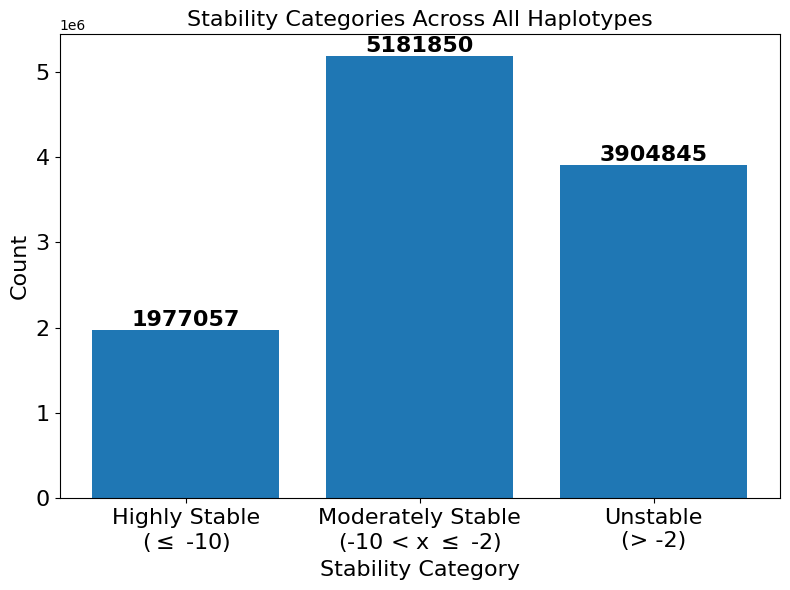

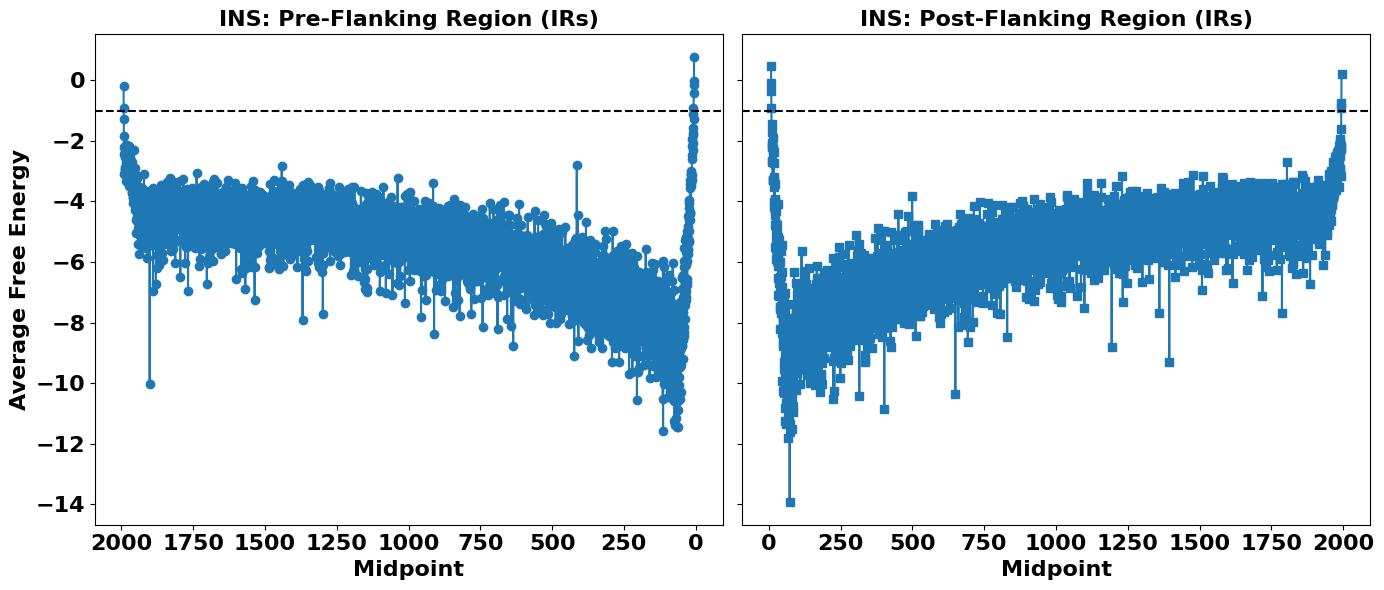

[OK] Saved: /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/average_free_energy_pre_post_INS.pdf


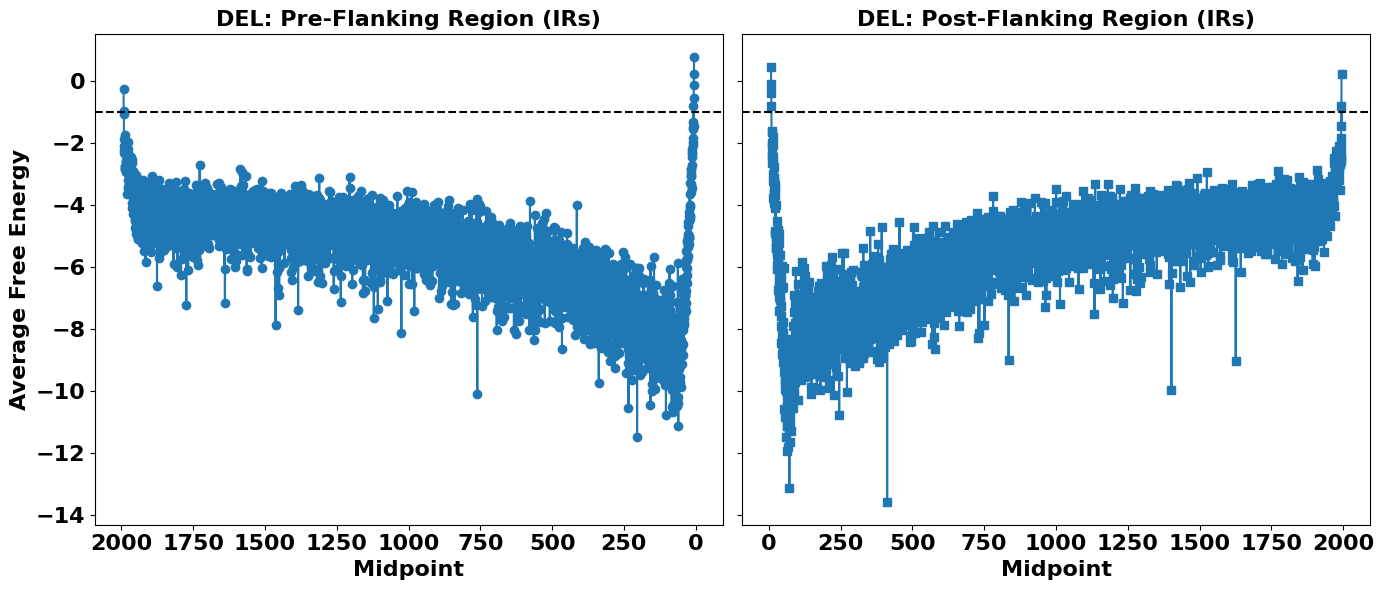

[OK] Saved: /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/average_free_energy_pre_post_DEL.pdf


In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import re

# Define the directory containing the TSV files
data_dir = "/home/alextu/projects/def-sushant/verkko_batch123_nonB_annotations_aligned_july2024/free_energy_IRs_SVs/"

# Find all `.tsv` files in the directory
tsv_files = glob.glob(os.path.join(data_dir, "*NA*.tsv"))

# Load all TSV files into a single DataFrame
all_data = []
for file in tsv_files:
    df = pd.read_csv(file, sep="\t")
    df["Haplotype"] = os.path.basename(file).split("_hap")[0]  # Extract sample ID
    all_data.append(df)

# Merge all data
df = pd.concat(all_data, ignore_index=True)

# ------------------------------
# Step 1: Categorize Stability
# ------------------------------
def categorize_stability(value):
    if value <= -10:
        return "Highly Stable\n($\\leq$ -10)"
    elif value <= -2:
        return "Moderately Stable\n(-10 < x $\\leq$ -2)"
    else:
        return "Unstable\n(> -2)"

# Detect the correct Free Energy column name and use it consistently
if "Free_Energy" in df.columns:
    FREE_COL = "Free_Energy"
elif "Q" in df.columns:
    FREE_COL = "Q"
else:
    raise ValueError("Neither 'Free_Energy' nor 'Q' columns found in the dataset.")

df["Stability"] = df[FREE_COL].apply(categorize_stability)

# ------------------------------
# Step 2: Extract Flanking Region
# ------------------------------
def extract_flank(sequence_name):
    try:
        return sequence_name.split('|')[-1]
    except Exception:
        return "Unknown"

df["Flank"] = df["Sequence_name"].apply(extract_flank)

# ------------------------------
# Step 3: Compute Mid Position
# ------------------------------
df["Mid_Position"] = (df["Start"] + df["Stop"]) / 2
#df["Mid_Position"] = df["Stop"]

# ------------------------------
# NEW: Extract SV Type (INS/DEL)
# ------------------------------
def extract_svtype(s):
    # Try Sequence_name first
    txt = str(s)
    m = re.search(r'(?:^|[._|\-])(INS|DEL)(?:[._|\-]|$)', txt, flags=re.IGNORECASE)
    if m:
        return m.group(1).upper()
    return "Unknown"

# Prefer Sequence_name; if it's missing, fall back to filename token if present
if "Sequence_name" in df.columns:
    df["SVType"] = df["Sequence_name"].apply(extract_svtype)
else:
    df["SVType"] = "Unknown"

# Keep only rows with identified SV type and known flank
df = df[(df["SVType"].isin(["INS", "DEL"])) & (df["Flank"].isin(["pre_flank", "post_flank"]))]

# ------------------------------
# Step 4: Count Stability Categories Across All Haplotypes (UNCHANGED)
# ------------------------------
stability_categories = [
    "Highly Stable\n($\\leq$ -10)", 
    "Moderately Stable\n(-10 < x $\\leq$ -2)", 
    "Unstable\n(> -2)"
]

stability_counts = df["Stability"].value_counts().reindex(stability_categories).fillna(0)

# ------------------------------
# Step 5: Plot Stability Categories Across All Haplotypes (UNCHANGED)
# ------------------------------
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(stability_categories, stability_counts, color="#1f77b4")  # Blue

# Add count labels
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h, f'{int(h)}', ha='center', va='bottom', fontsize=16, fontweight='bold')

ax.set_xlabel("Stability Category", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.set_title("Stability Categories Across All Haplotypes", fontsize=16)
ax.set_xticks(range(len(stability_categories)))
ax.set_xticklabels(stability_categories, fontsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.tight_layout()
plt.savefig('stability_categories_all_haplotypes.pdf', format='pdf', dpi=300)
plt.show()

# ------------------------------
# Step 6: Compute Average Free Energy By Flanking Region & Mid_Position
# ------------------------------
avg_free_energy = (
    df.groupby(["Flank", "Mid_Position"])[FREE_COL]
      .mean()
      .reset_index()
      .rename(columns={FREE_COL: "Free_Energy_Avg"})
)

# ------------------------------
# Helper: Plot pre vs post for a given SV type (INS or DEL)
# ------------------------------
def plot_pre_post_for_svtype(df_all, svtype_label, out_pdf):
    sub = df_all[df_all["SVType"] == svtype_label]
    if sub.empty:
        print(f"[WARN] No rows for {svtype_label}; skipping {out_pdf}")
        return

    avg_fe = (
        sub.groupby(["Flank", "Mid_Position"])[FREE_COL]
           .mean()
           .reset_index()
           .rename(columns={FREE_COL: "Free_Energy_Avg"})
           .sort_values(["Flank", "Mid_Position"])
    )

    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Pre-flank
    pre_flank = avg_fe[avg_fe["Flank"] == "pre_flank"]
    axs[0].plot(pre_flank["Mid_Position"], pre_flank["Free_Energy_Avg"], color='#1f77b4', marker='o')
    axs[0].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)
    axs[0].set_title(f"{svtype_label}: Pre-Flanking Region (IRs)", fontsize=16, fontweight='bold')
    axs[0].set_xlabel("Midpoint", fontsize=16, fontweight='bold')
    axs[0].set_ylabel("Average Free Energy", fontsize=16, fontweight='bold')
    #axs[0].grid(True, linestyle='--', alpha=0.5)
    # --- Fix x-axis ticks for pre-flank (display 2000→0 labels only) ---
    axs[0].set_xticks(range(0, 2001, 250))                  # tick positions
    axs[0].set_xticklabels([str(2000 - x) for x in range(0, 2001, 250)])  # flipped labels
    axs[0].tick_params(axis='x', labelrotation=0)

    # Post-flank
    post_flank = avg_fe[avg_fe["Flank"] == "post_flank"]
    axs[1].plot(post_flank["Mid_Position"], post_flank["Free_Energy_Avg"], color='#1f77b4', marker='s')
    axs[1].axhline(y=-1, color='black', linestyle='--', linewidth=1.5)
    axs[1].set_title(f"{svtype_label}: Post-Flanking Region (IRs)", fontsize=16, fontweight='bold')
    axs[1].set_xlabel("Midpoint", fontsize=16, fontweight='bold')
    #axs[1].grid(True, linestyle='--', alpha=0.5)

    for tick in axs[0].get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)

    for tick in axs[0].get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)

    for tick in axs[1].get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)

    for tick in axs[1].get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)

    #plt.suptitle(f"Average Free Energy Of Inverted Repeats in SV Flanks — {svtype_label}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(out_pdf, format='pdf', dpi=300)
    plt.show()
    print(f"[OK] Saved: {out_pdf}")

# ------------------------------
# Plot: INS (pre vs post)
# ------------------------------
plot_pre_post_for_svtype(df, "INS", "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/average_free_energy_pre_post_INS.pdf")

# ------------------------------
# Plot: DEL (pre vs post)
# ------------------------------
plot_pre_post_for_svtype(df, "DEL", "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/average_free_energy_pre_post_DEL.pdf")

Dataset loaded successfully.


/tmp/ipykernel_5346/764328092.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_xticklabels([int(max(ticks) - t) for t in ticks])


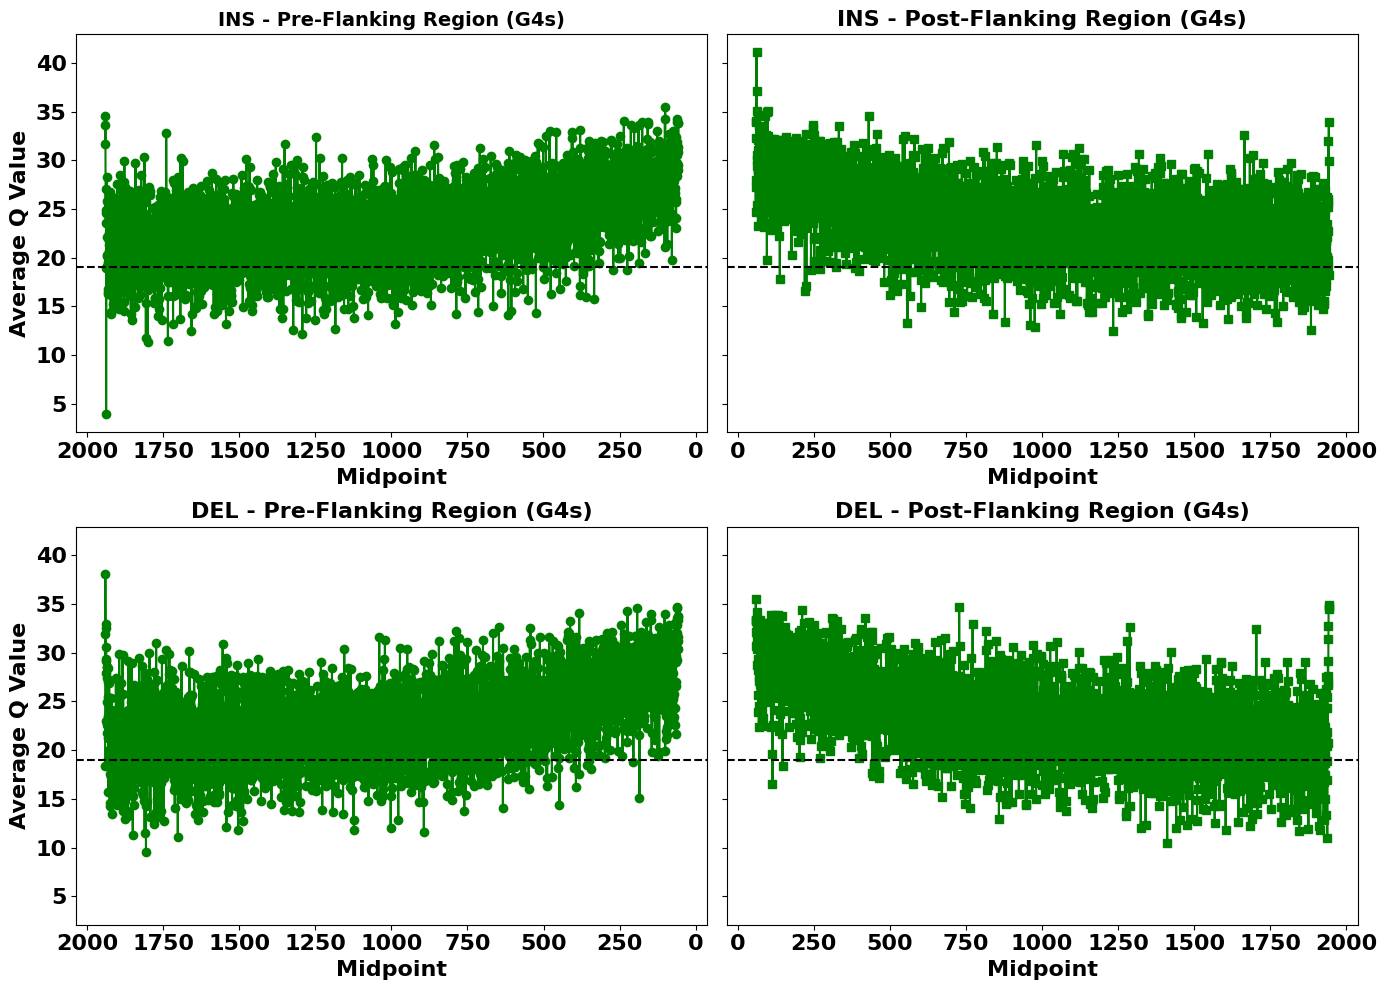

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# -------------------
# Step 1: Load and Process the Data
# -------------------

# Define the file path (Modify this to the specific file you want to analyze)
file_path = "/scratch/alextu/extract_sv_flanks_2000bp/all_combined_quadron_results_SV_flanks.csv"

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    exit(1)
except pd.errors.EmptyDataError:
    print(f"Error: The file '{file_path}' is empty.")
    exit(1)
except pd.errors.ParserError:
    print(f"Error: The file '{file_path}' is malformed or not in CSV format.")
    exit(1)

# Drop rows where Q or L values are NA
df = df.dropna(subset=['Q', 'L'])

# Ensure 'POS' and 'L' are numeric
df['POS'] = pd.to_numeric(df['POS'], errors='coerce')
df['L'] = pd.to_numeric(df['L'], errors='coerce')

# Drop rows where conversion failed
df = df.dropna(subset=['POS', 'L'])

# Compute the **midpoint** between POS and L
df["Midpoint"] = (df["POS"] + (df["POS"] + df["L"])) / 2

# ------------------------------
# **Step 2: Extract Structural Variant Type (INS/DEL)**
# ------------------------------
def extract_sv_type(sample_name):
    if "_INS" in sample_name:
        return "INS"
    elif "_DEL" in sample_name:
        return "DEL"
    else:
        return "Unknown"

df["SV_Type"] = df["Sample"].apply(extract_sv_type)

# Keep only INS and DEL entries (ignore "Unknown")
df = df[df["SV_Type"].isin(["INS", "DEL"])]

# ------------------------------
# **Step 3: Extract Flanking Region**
# ------------------------------
def extract_flank(sample_name):
    match = re.search(r'_(pre|post)_flank\.txt$', sample_name)
    return f"{match.group(1)}_flank" if match else "Unknown"

df["Flank"] = df["Sample"].apply(extract_flank)

# ------------------------------
# **Step 4: Compute Average Q By Flank, Midpoint, and SV Type**
# ------------------------------
average_q = df.groupby(["SV_Type", "Flank", "Midpoint"])["Q"].mean().reset_index()

# ------------------------------
# **Step 5: Plot Aggregated Stability Trends (INS vs DEL)**
# ------------------------------
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

# -------------------
# Subplot 1: INS - Pre-Flank
# -------------------
pre_flank_ins = average_q[(average_q["SV_Type"] == "INS") & (average_q["Flank"] == "pre_flank")]
axs[0, 0].plot(pre_flank_ins["Midpoint"], pre_flank_ins["Q"], color='green', marker='o')

axs[0, 0].axhline(y=19, color='black', linestyle='--', linewidth=1.5)  # Line at 19
axs[0, 0].set_title("INS - Pre-Flanking Region (G4s)", fontsize=14, fontweight='bold')
axs[0, 0].set_xlabel("Midpoint", fontsize=16)
axs[0, 0].set_ylabel("Average Q Value", fontsize=16)
#axs[0, 0].grid(True, linestyle='--', alpha=0.5)
ticks = axs[0, 0].get_xticks()
axs[0, 0].set_xticklabels([int(max(ticks) - t) for t in ticks])

# -------------------
# Subplot 2: INS - Post-Flank
# -------------------
post_flank_ins = average_q[(average_q["SV_Type"] == "INS") & (average_q["Flank"] == "post_flank")]
axs[0, 1].plot(post_flank_ins["Midpoint"], post_flank_ins["Q"], color='green', marker='s')

axs[0, 1].axhline(y=19, color='black', linestyle='--', linewidth=1.5)  # Line at 19
axs[0, 1].set_title("INS - Post-Flanking Region (G4s)", fontsize=16, fontweight='bold')
axs[0, 1].set_xlabel("Midpoint", fontsize=12)
#axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Subplot 3: DEL - Pre-Flank
# -------------------
pre_flank_del = average_q[(average_q["SV_Type"] == "DEL") & (average_q["Flank"] == "pre_flank")]
axs[1, 0].plot(pre_flank_del["Midpoint"], pre_flank_del["Q"], color='green', marker='o')

axs[1, 0].axhline(y=19, color='black', linestyle='--', linewidth=1.5)  # Line at 19
axs[1, 0].set_title("DEL - Pre-Flanking Region (G4s)", fontsize=16, fontweight='bold')
axs[1, 0].set_xlabel("Midpoint", fontsize=12)
axs[1, 0].set_ylabel("Average Q Value", fontsize=12)
#axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# -------------------
# Subplot 4: DEL - Post-Flank
# -------------------
post_flank_del = average_q[(average_q["SV_Type"] == "DEL") & (average_q["Flank"] == "post_flank")]
axs[1, 1].plot(post_flank_del["Midpoint"], post_flank_del["Q"], color='green', marker='s')

axs[1, 1].axhline(y=19, color='black', linestyle='--', linewidth=1.5)  # Line at 19
axs[1, 1].set_title("DEL - Post-Flanking Region (G4s)", fontsize=16, fontweight='bold')
axs[1, 1].set_xlabel("Midpoint", fontsize=12)
#axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# --- Fix x-axis ticks for pre-flanks ---
for ax in [axs[0, 0], axs[1, 0]]:  # both INS and DEL pre-flanks
    # Force fixed tick positions from 0–2000 based on your flank length
    ax.set_xticks(range(0, 2001, 250))  # adjust step if you want fewer labels
    # Now flip just the labels to count down from 2000 to 0
    ax.set_xticklabels([str(2000 - x) for x in range(0, 2001, 250)])
    # Optional: make sure labels display cleanly
    ax.tick_params(axis='x', labelrotation=0)

# === Bold X/Y ticks + labels for ALL subplots ===
for ax in axs.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=16, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=16, fontweight='bold')

    for tick in ax.get_xticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)
    for tick in ax.get_yticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(16)
        

# -------------------
# Formatting & Saving
# -------------------
#plt.suptitle("Average Stability (Q) Of G-Quadruplexes in SV Flanks (INS vs DEL)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/average_Q_G4_INS_vs_DEL.pdf', format='pdf', dpi=300)
plt.show()


=== Median OR for INS ===
G4–inter: median OR = 12.58
G4–intra: median OR = 16.94
IR–inter: median OR = 18.53
IR–intra: median OR = 21.01

=== Median OR for DEL ===
G4–inter: median OR = 2.13
G4–intra: median OR = 1.82
IR–inter: median OR = 7.33
IR–intra: median OR = 10.75


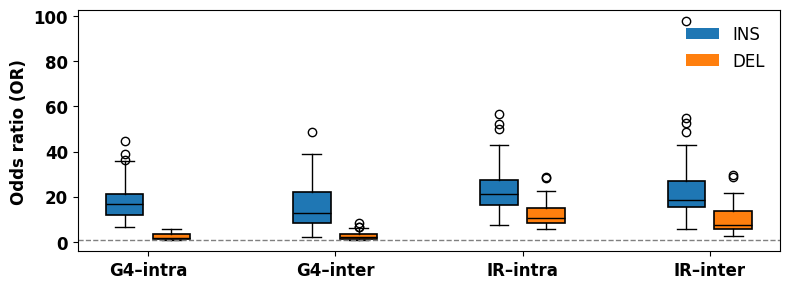

[saved] /home/alextu/projects/def-sushant/alextu/imgs_no_titles2/sv_or_boxplots_FIXED_intra_inter_oneplot/OR_INS_vs_DEL_G4_IR_intra_inter.pdf


In [13]:
#!/usr/bin/env python3
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ========= CONFIG =========
INS_RES = "/home/alextu/projects/def-sushant/alextu/inside_SVs_chm13_HGSVC3/INS_nonB_SDxSV_fisher_FIXED.filtered.tsv"
DEL_RES = "/home/alextu/projects/def-sushant/alextu/inside_SVs_chm13_HGSVC3/DEL_nonB_SDxSV_fisher_FIXED.filtered.tsv"
OUT_DIR = "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/sv_or_boxplots_FIXED_intra_inter_oneplot"
MOTIFS  = ["G4", "IR"]                 # motifs to show
KEEP_SD = ["intra", "inter"]           # drop "all"
COLORS  = {"INS": "#1f77b4", "DEL": "#ff7f0e"}
# ==========================

os.makedirs(OUT_DIR, exist_ok=True)

def load_and_prep(path, svtype_expected):
    df = pd.read_csv(path, sep="\t")
    need = {"sample","hap","SVTYPE","motif","OR","sd_type"}
    miss = need - set(df.columns)
    if miss:
        raise ValueError(f"{path} missing columns: {miss}")

    df = df[df["SVTYPE"] == svtype_expected].copy()
    df["OR"] = pd.to_numeric(df["OR"], errors="coerce")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=["OR","sd_type","motif"], inplace=True)
    df = df[df["OR"] > 0]

    # keep only target motifs and sd types
    df["sd_type"] = df["sd_type"].str.lower().str.strip()
    df = df[df["motif"].isin(MOTIFS) & df["sd_type"].isin(KEEP_SD)]

    # build a combined label for x-axis grouping
    df["group"] = df["motif"] + "–" + df["sd_type"]
    return df

ins = load_and_prep(INS_RES, "INS")
deL = load_and_prep(DEL_RES, "DEL")

# Ensure consistent order of x-axis groups
group_order = [f"{m}–{sd}" for m in MOTIFS for sd in KEEP_SD]

# Prepare data arrays per group (one INS and one DEL box per group)
data_ins = [ins.loc[ins["group"] == g, "OR"].values for g in group_order]
data_del = [deL.loc[deL["group"] == g, "OR"].values for g in group_order]

# ---- Print median OR per category ----
for svtype, df in [("INS", ins), ("DEL", deL)]:
    print(f"\n=== Median OR for {svtype} ===")
    med = (df.groupby(["motif", "sd_type"])["OR"]
             .median()
             .reset_index()
             .sort_values(["motif", "sd_type"]))
    for _, r in med.iterrows():
        print(f"{r['motif']}–{r['sd_type']}: median OR = {r['OR']:.2f}")

# ---- Plot: two boxes per group (INS vs DEL) ----
plt.figure(figsize=(8, 3))
positions = np.arange(1, len(group_order)*2 + 1, 2)  # centers for each group

# INS (left offset)
if any(arr.size for arr in data_ins):
    bp1 = plt.boxplot(
        data_ins, positions=positions - 0.25, widths=0.40,
        patch_artist=True, boxprops=dict(linewidth=1.2),
        medianprops=dict(color="black"), tick_labels=[""]*len(group_order)
    )
    for b in bp1["boxes"]:
        b.set_facecolor(COLORS["INS"])

# DEL (right offset)
if any(arr.size for arr in data_del):
    bp2 = plt.boxplot(
        data_del, positions=positions + 0.25, widths=0.40,
        patch_artist=True, boxprops=dict(linewidth=1.2),
        medianprops=dict(color="black"), tick_labels=[""]*len(group_order)
    )
    for b in bp2["boxes"]:
        b.set_facecolor(COLORS["DEL"])

# X ticks labeled as motif–sdtype
plt.xticks(positions, group_order, rotation=0, fontsize=11, fontweight="bold")
# === Bold all tick labels ===
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(12)
for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(12)

# Reference line at OR=1
plt.axhline(1, color="gray", linestyle="--", linewidth=1)

plt.ylabel("Odds ratio (OR)", fontsize=12, fontweight="bold")
#plt.title("G4 & IR enrichment in SVs overlapping fixed SDs (intra vs inter)", fontsize=13, fontweight="bold")

# Legend
legend_patches = [
    Patch(facecolor=COLORS["INS"], label="INS"),
    Patch(facecolor=COLORS["DEL"], label="DEL"),
]
plt.legend(handles=legend_patches, loc="upper right", frameon=False, fontsize = 12)

plt.tight_layout()
out_path = os.path.join(OUT_DIR, "OR_INS_vs_DEL_G4_IR_intra_inter.pdf")
plt.savefig(out_path, dpi=300, bbox_inches = 'tight')
plt.show()
print(f"[saved] {out_path}")

# Figure 6 - Non-B DNA and Mobile Element Insertions

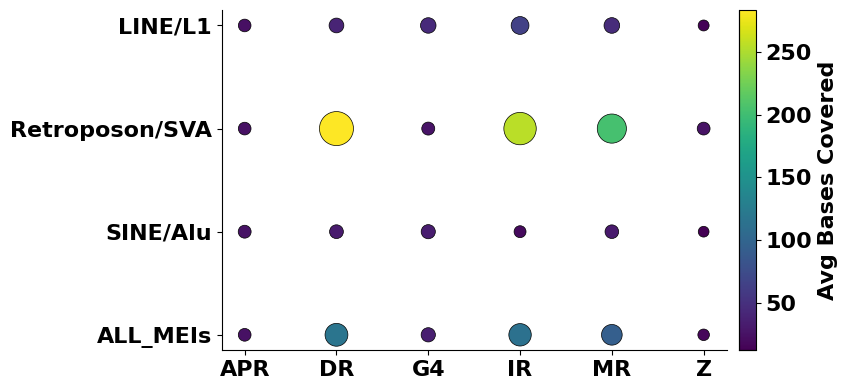

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

# === Load your data ===
df_nonb = pd.read_csv("/home/alextu/scratch/mei_analysis/MEIannotations_summary_metrics_chr_with_TE_designations.csv")
df_g4 = pd.read_csv("/home/alextu/scratch/mei_analysis/all_combined_quadron_results_MEI_sequences_with_TE_designations.csv")

# === Extract Sample identifiers ===
df_nonb['Sample'] = df_nonb['Sample_Haplotype_Chromosome'].str.split(r"\|").str[0]
df_g4['Sample'] = df_g4['Sample'].str.split(r"_").str[0]

# === Compute mean "Total Bases Covered" per Sample, Motif, TE ===
sample_motif_te_avg_nonb = (
    df_nonb.groupby(['Sample', 'Motif Type', 'te_designation'])['Total Bases Covered']
    .mean()
    .reset_index(name='avg_total_bases_covered')
)

sample_motif_te_avg_g4 = (
    df_g4.groupby(['Sample', 'te_designation'])["L"]
    .mean()
    .reset_index(name='avg_total_bases_covered')
)
sample_motif_te_avg_g4["Motif Type"] = "G4"

# === Combine datasets ===
sample_motif_te_avg = pd.concat([sample_motif_te_avg_nonb, sample_motif_te_avg_g4], ignore_index=True)

# === REMOVE snRNA ===
sample_motif_te_avg = sample_motif_te_avg[sample_motif_te_avg["te_designation"] != "snRNA"]

# === Group by Motif Type + TE Designation ===
heatmap_data = (
    sample_motif_te_avg
    .groupby(['te_designation', 'Motif Type'])['avg_total_bases_covered']
    .mean()
    .reset_index()
)

# === Add ALL_MEIs row: mean across all TE designations per Motif Type ===
all_meis = (
    heatmap_data
    .groupby("Motif Type")["avg_total_bases_covered"]
    .mean()
    .reset_index()
)
all_meis["te_designation"] = "ALL_MEIs"

heatmap_data = pd.concat(
    [heatmap_data, all_meis[["te_designation", "Motif Type", "avg_total_bases_covered"]]],
    ignore_index=True
)

# --- Compute normalization ---
vmin = heatmap_data['avg_total_bases_covered'].min()
vmax = heatmap_data['avg_total_bases_covered'].max()
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# --- Modern colormap getter (Matplotlib ≥3.7) ---
cmap = plt.colormaps.get_cmap("viridis")

plt.figure(figsize=(8.5, 4))
scatter = sns.scatterplot(
    data=heatmap_data,
    x="Motif Type",
    y="te_designation",
    size="avg_total_bases_covered",
    hue="avg_total_bases_covered",
    hue_norm=(vmin, vmax),
    palette=cmap,
    sizes=(60, 600),
    legend=False,  # we'll add proper colorbar + size legend
    edgecolor="black",
    linewidth=0.5
)

# Bold x and y tick labels
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)
    
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
    tick.set_fontsize(16)

# --- Continuous COLORBAR (includes yellow) ---
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter, pad=0.02)
cbar.set_label("Avg Bases Covered", fontsize=16, fontweight="bold")
cbar.ax.tick_params(labelsize=16)

for tick in cbar.ax.get_yticklabels():
    tick.set_fontweight("bold")


sns.despine()
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/avg_bases_mei.pdf", dpi=300)
plt.show()

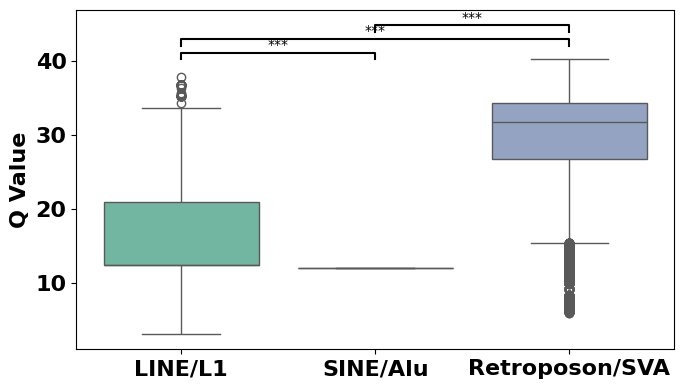

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Optional: If you have statannotations, use it
try:
    from statannotations.Annotator import Annotator
    USE_STATANNOT = True
except ImportError:
    USE_STATANNOT = False

# Load and preprocess
df = pd.read_csv("/home/alextu/scratch/mei_analysis/all_combined_quadron_results_MEI_sequences_with_TE_designations.csv")
df['Q'] = pd.to_numeric(df['Q'], errors='coerce')
df = df.dropna(subset=["Q", "te_designation"])
df = df[df["te_designation"] != "snRNA"]

# Unique TE classes
te_classes = df["te_designation"].unique()
pairs = list(combinations(te_classes, 2))

# Run pairwise Wilcoxon tests
pvals = []
for g1, g2 in pairs:
    q1 = df[df["te_designation"] == g1]["Q"]
    q2 = df[df["te_designation"] == g2]["Q"]
    stat, p = ranksums(q1, q2)
    pvals.append(p)

# Adjust p-values
adjusted = multipletests(pvals, method="fdr_bh")[1]
pval_dict = {pair: p for pair, p in zip(pairs, adjusted)}

set2_colors = sns.color_palette("Set2")
custom_palette = {
    "LINE/L1": set2_colors[0],         # green
    "Retroposon/SVA": set2_colors[2],  # blue
    "SINE/Alu": set2_colors[1],        # orange
}

desired_order = ["LINE/L1", "SINE/Alu", "Retroposon/SVA"]
df = df[df["te_designation"].isin(desired_order)]  # Filter to desired TE classes
df["te_designation"] = pd.Categorical(df["te_designation"], categories=desired_order, ordered=True)

# === PLOT
plt.figure(figsize=(7, 4))
ax = sns.boxplot(
    data=df,
    x="te_designation",
    y="Q",
    hue="te_designation",
    palette=custom_palette,
    dodge=False,
    legend=False
)
plt.xlabel("", fontsize=16)
plt.ylabel("Q Value", fontsize=16, fontweight='bold')
#plt.title("G4 Stability Values by TE Designation", fontsize=12, fontweight="bold")
plt.xticks(rotation=0)
# === Bold tick labels ===
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

# === Add annotations
if USE_STATANNOT:
    annotator = Annotator(ax, pairs, data=df, x="te_designation", y="Q")
    annotator.set_pvalues_and_annotate(list(pval_dict.values()), correction_format="star")
else:
    # fallback manual stars
    y_max = df["Q"].max()
    h = (y_max - df["Q"].min()) * 0.05
    for i, ((g1, g2), p) in enumerate(pval_dict.items()):
        x1, x2 = te_classes.tolist().index(g1), te_classes.tolist().index(g2)
        y = y_max + i * h
        bar_x = [x1, x1, x2, x2]
        bar_y = [y, y + h / 2, y + h / 2, y]
        plt.plot(bar_x, bar_y, c="black")
        star = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        plt.text((x1 + x2) / 2, y + h / 2 + h * 0.05, star, ha="center", va="bottom")

plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/G4_mei_free_energy.pdf", dpi=300)
plt.show()

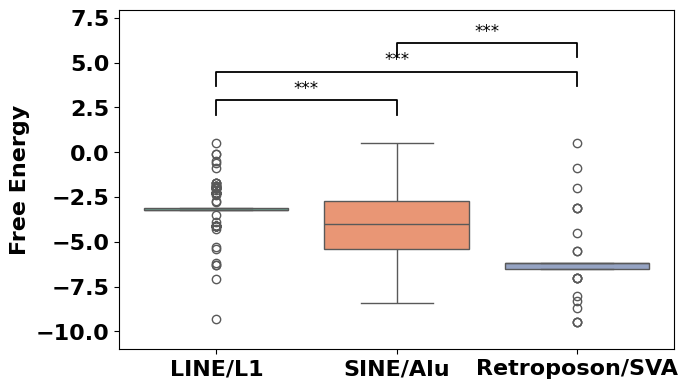

    Group 1         Group 2  KS Statistic   Raw p-value   Adj p-value
0   LINE/L1        SINE/Alu      0.512529  4.202720e-14  4.202720e-14
1   LINE/L1  Retroposon/SVA      0.886895  1.726002e-49  5.178005e-49
2  SINE/Alu  Retroposon/SVA      0.815617  1.167687e-27  1.751530e-27


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# -------------------
# Load and Process the Data
# -------------------

# Define the file paths
hap1_file = "/home/alextu/scratch/mei_analysis/free_energy_IRS_MEI_sequence_annotated/HG00096.h1.MEI_IR_free_energy.tsv"
hap2_file = "/home/alextu/scratch/mei_analysis/free_energy_IRS_MEI_sequence_annotated/HG03520.h1.MEI_IR_free_energy.tsv"

# Load the datasets
hap1_df = pd.read_csv(hap1_file, sep="\t")
hap2_df = pd.read_csv(hap2_file, sep="\t")

# Column for Free Energy
energy_col = 'Free_Energy'

# Remove duplicates based on Sequence_name
hap1_df = hap1_df.drop_duplicates(subset=["Sequence_name"])
hap2_df = hap2_df.drop_duplicates(subset=["Sequence_name"])

# Combine both haplotypes
combined_df = pd.concat([hap1_df, hap2_df])

# Drop NAs just in case
combined_df = combined_df.dropna(subset=[energy_col, "te_designation"])
tes = list(combined_df["te_designation"].unique())

# -------------------
# Create Boxplot of Free Energy by TE Designation
# -------------------

plt.figure(figsize=(7, 4))
ax = sns.boxplot(data=combined_df, x="te_designation", y=energy_col, hue="te_designation", palette="Set2", legend=False)

plt.xlabel("", fontsize=12)
plt.ylabel("Free Energy", fontsize=16, fontweight='bold')
#plt.title("IR Free Energy by TE Designation", fontsize=12, fontweight="bold")
plt.xticks(rotation=0)
#plt.grid(axis="y", linestyle="--", alpha=0.7)
# === Bold tick labels ===
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

# -------------------
# Pairwise KS Tests + FDR Correction
# -------------------

results = []
pairs = list(combinations(tes, 2))

for g1, g2 in pairs:
    d1 = combined_df[combined_df["te_designation"] == g1][energy_col]
    d2 = combined_df[combined_df["te_designation"] == g2][energy_col]
    stat, p = ks_2samp(d1, d2)
    results.append((g1, g2, stat, p))

results_df = pd.DataFrame(results, columns=["Group 1", "Group 2", "KS Statistic", "Raw p-value"])

# FDR correction
results_df["Adj p-value"] = multipletests(results_df["Raw p-value"], method="fdr_bh")[1]

# -------------------
# Annotate Significance
# -------------------

y_max = combined_df[energy_col].max()
h = (y_max - combined_df[energy_col].min()) * 0.05
offset = y_max + h

for i, row in results_df.iterrows():
    g1, g2 = row["Group 1"], row["Group 2"]
    p = row["Adj p-value"]
    x1, x2 = tes.index(g1), tes.index(g2)
    y = offset + i * h

    # Plot connector line
    plt.plot([x1, x1, x2, x2], [y, y + h/2, y + h/2, y], lw=1.3, c="black")

    # Decide star label
    star = (
        "***" if p < 0.001 else
        "**" if p < 0.01 else
        "*" if p < 0.05 else
        "ns"
    )
    plt.text((x1 + x2) / 2, y + h * 0.6, star, ha="center", va="bottom", fontsize=12)
    
plt.ylim(bottom=-11)    
plt.tight_layout()
plt.savefig("/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/IR_mei_free_energy.pdf", dpi=300)
plt.show()

# Display raw + adjusted results
print(results_df)

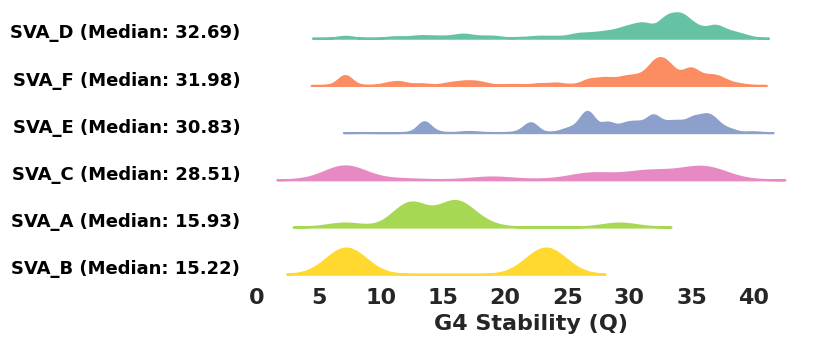

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load and preprocess data
df = pd.read_csv("/home/alextu/scratch/mei_analysis/all_combined_quadron_results_MEI_sequences_with_TE_designations.csv")
df['Q'] = pd.to_numeric(df['Q'], errors='coerce')
df = df.dropna(subset=["Q", "te_designation", "l1me_aid_info"])
df = df[df["te_designation"] == "Retroposon/SVA"]

# === Extract RM_Annotation
df["RM_Annotation"] = df["l1me_aid_info"].str.extract(r"RM_Annotation:([^;]+)")

# === Order RM annotations by median Q
medians = df.groupby("RM_Annotation")["Q"].median().sort_values(ascending=False)
ordered_rms = medians.index.tolist()
df["RM_Annotation"] = pd.Categorical(df["RM_Annotation"], categories=ordered_rms, ordered=True)

# === Ridge plot setup
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(
    df,
    row="RM_Annotation",
    hue="RM_Annotation",
    aspect=14,     # Wider (was 5)
    height=0.6,   # Shorter height per ridge
    palette="Set2",
    row_order=ordered_rms
)

g.map(sns.kdeplot, "Q",
      bw_adjust=0.5,
      clip_on=False,
      fill=True,
      alpha=1,
      linewidth=1.5)

# === Add annotation labels and medians
for ax, label in zip(g.axes.flat, ordered_rms):
    median_q = medians[label]
    ax.text(-0.02, 0.2, f"{label} (Median: {median_q:.2f})",
            fontweight="bold",
            fontsize=13,
            color="black",
            ha="right",
            va="center",
            transform=ax.transAxes)

# === Final formatting
g.figure.subplots_adjust(hspace=-0.7)
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel="G4 Stability (Q)")
g.despine(bottom=True, left=True)

# === Bold X-axis ticks and label ===
for ax in g.axes.flat:
    # Bold tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontweight("bold")
        tick.set_fontsize(16)

# Bold the shared X-axis label
g.set_xlabels("G4 Stability (Q)", fontsize=16, fontweight="bold")

#plt.suptitle("G4 Stability Across Retroposon/SVA Annotations", fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/G4_stability_SVA_age.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

Total unique MEIs: 11277


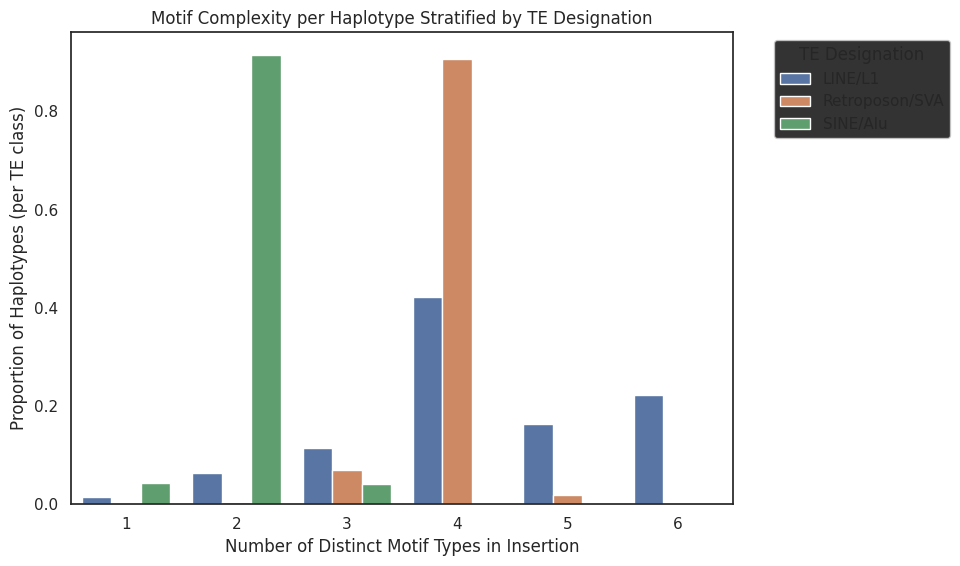


Most common SINGLE motif types:
  Count  count
0    MR   2450
1    IR   1101
2    DR    391
3    G4     51

Most common MULTI motif combinations:
                Count  count
0               DR,MR  78915
1         DR,G4,IR,MR  10989
2            DR,IR,MR   4483
3   APR,DR,G4,IR,MR,Z   3222
4     APR,DR,G4,IR,MR   2308
5               G4,IR    907
6         APR,G4,IR,Z    847
7            G4,IR,MR    641
8           APR,G4,IR    265
9            DR,G4,IR    196
10       APR,DR,G4,IR    108
11     APR,G4,IR,MR,Z    106
12       APR,G4,IR,MR     72
13              IR,MR     57
14      DR,G4,IR,MR,Z     57
15            G4,IR,Z     36
16           DR,G4,MR     35
17               MR,Z     35
18     APR,DR,IR,MR,Z     17
19          APR,DR,MR      6
20            DR,MR,Z      2
21       APR,DR,IR,MR      1


<Figure size 1000x600 with 0 Axes>

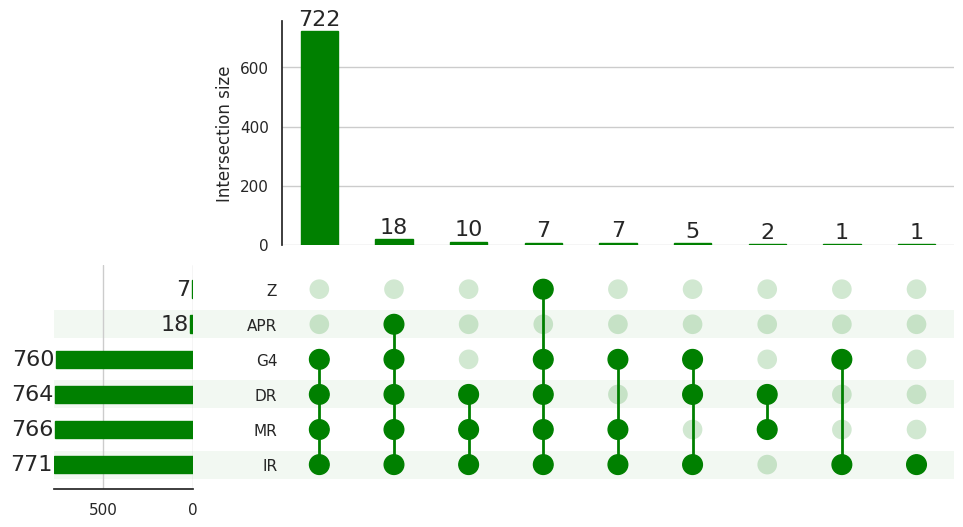

In [41]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import UpSet, from_memberships
import warnings

# === Suppress future warnings from pandas/upsetplot ===
warnings.filterwarnings("ignore", category=FutureWarning)

# === Load data ===
df_nonb = pd.read_csv("/home/alextu/scratch/mei_analysis/MEIannotations_summary_metrics_chr_with_TE_designations.csv")
df_g4 = pd.read_csv("/home/alextu/scratch/mei_analysis/all_combined_quadron_results_MEI_sequences_with_TE_designations.csv")

# === Standardize sample and motif columns ===
df_nonb["Sample"] = df_nonb["Sample_Haplotype_Chromosome"].str.split(r"\|").str[0]
df_g4["Sample"] = df_g4["Sample"].str.split(r"_").str[0]
df_g4["Motif Type"] = "G4"

df_nonb = df_nonb[["identifier", "Motif Type", "Sample", "te_designation"]]
df_g4 = df_g4[["identifier", "Motif Type", "Sample", "te_designation"]]

# === Combine, deduplicate, and filter ===
df = pd.concat([df_nonb, df_g4], ignore_index=True).drop_duplicates()
df = df[df["te_designation"] != "snRNA"]

print("Total unique MEIs:", df["identifier"].nunique())

# === Count motif types per MEI+sample ===
motif_counts = (
    df.groupby(["identifier", "Sample"])
    .agg(
        motif_type_count=("Motif Type", "nunique"),
        te_designation=("te_designation", lambda x: x.iloc[0])
    )
    .reset_index()
)

# === Barplot: Motif complexity per TE class ===
count_table = (
    motif_counts.groupby(["te_designation", "motif_type_count"])
    .size()
    .reset_index(name="Num_Haplotypes")
)

# Normalize per TE
total_per_te = count_table.groupby("te_designation")["Num_Haplotypes"].transform("sum")
count_table["Proportion"] = count_table["Num_Haplotypes"] / total_per_te

plt.figure(figsize=(10, 6))
sns.barplot(data=count_table, x="motif_type_count", y="Proportion", hue="te_designation")
plt.title("Motif Complexity per Haplotype Stratified by TE Designation")
plt.xlabel("Number of Distinct Motif Types in Insertion")
plt.ylabel("Proportion of Haplotypes (per TE class)")
plt.legend(title="TE Designation", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# === Most common SINGLE motif types ===
single_motif = df.groupby(["identifier", "Sample"]).filter(
    lambda x: x["Motif Type"].nunique() == 1
)
single_motif_types = (
    single_motif.groupby(["identifier", "Sample"])["Motif Type"]
    .first()
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Motif Type", "Motif Type": "Count"})
)
print("\nMost common SINGLE motif types:")
print(single_motif_types)

# === Most common MULTI motif combinations ===
multi_motif = df.groupby(["identifier", "Sample"]).filter(
    lambda x: x["Motif Type"].nunique() > 1
)
multi_motif_combo = (
    multi_motif.groupby(["identifier", "Sample"])["Motif Type"]
    .apply(lambda x: ",".join(sorted(set(x))))
    .value_counts()
    .reset_index()
    .rename(columns={"index": "Motif Combo", "Motif Type": "Count"})
)
print("\nMost common MULTI motif combinations:")
print(multi_motif_combo)

# === Assign TE class to each MEI ===
te_map = df.groupby("identifier")["te_designation"].first().to_dict()
df["TE_Class"] = df["identifier"].map(te_map)

# === Build motif set per MEI ===
combo_df = (
    df.groupby("identifier")
    .agg(
        Motif_Set=("Motif Type", lambda x: sorted(set(x))),
        TE_Class=("TE_Class", "first")
    )
    .reset_index()
)

# === Color map per TE class ===
te_colors = {
    "L1": "royalblue",
    "Alu": "seagreen",
    "SVA": "darkorange",
    "ERV": "crimson",
    "HERV": "mediumorchid"
}

# === UpSet plot per TE class (inline, no saving) ===
te = "Retroposon/SVA"

subset = combo_df[combo_df["TE_Class"] == te]
if not subset.empty:
    combo_counts = subset["Motif_Set"].value_counts()
    upset_input = from_memberships(combo_counts.index.tolist(), data=combo_counts.values)

    fig = plt.figure(figsize=(10, 6))
    upset = UpSet(
        upset_input,
        sort_by='cardinality',
        show_counts=True,
        element_size=None,
        facecolor=te_colors.get(te, 'green')  # use SVA color
    )

    matplotlib.rcParams["font.size"] = 16
    upset.plot()

    # ========= ADD THIS BLOCK (font sizes) =========
    for ax in fig.axes:
        ax.tick_params(axis="both", labelsize=40)

        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontweight("bold")

        for text in ax.texts:           # counts above bars
            text.set_fontsize(40)
            text.set_fontweight("bold")
    # ===============================================

    #plt.suptitle(f"Non-B DNA Motif Combinations for {te}", fontsize=14, weight='bold')
    plt.subplots_adjust(left=0.05, right=0.95, top=0.88, bottom=0.1)

    plt.savefig(
        "/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/upset_Retroposon_SVA.pdf",
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
else:
    print(f"No entries found for {te}")



(260653, 5)
Total MEIs with exactly G4, DR, MR, IR and Retroposon/SVA: 722
Example filtered MEIs:
 3     chr10_101769464_2944_INS
5     chr10_102379879_1100_INS
6     chr10_102679419_3058_INS
9     chr10_102863249_1620_INS
84    chr10_119809227_3445_INS
Name: identifier, dtype: object
Collected 2368 DR motifs
Collected 1880 MR motifs
Collected 9135 IR motifs
G4 motifs after identifier filter: 68592
G4 identifiers (first 5): ['chr12_119816590_3487_INS' 'chr12_50567396_3160_INS'
 'chr13_34969457_2153_INS' 'chr13_42185734_1646_INS'
 'chr13_48598357_2334_INS']
Collected 9015 G4 motifs
Motif counts in final plot:
Motif
IR    9135
G4    9015
DR    2368
MR    1880
Name: count, dtype: int64


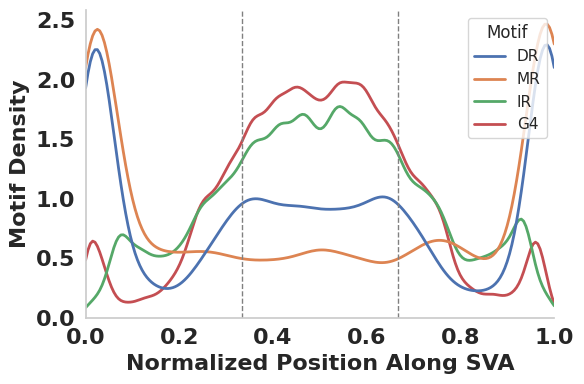

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

sns.set(style="whitegrid")

# === Step 1: Load and filter MEIs ===
df_nonb = pd.read_csv("/home/alextu/scratch/mei_analysis/MEIannotations_summary_metrics_chr_with_TE_designations.csv")
df_g4_csv = pd.read_csv("/home/alextu/scratch/mei_analysis/all_combined_quadron_results_MEI_sequences_with_TE_designations.csv")

# Extract Sample info and standardize
df_nonb["Sample"] = df_nonb["Sample_Haplotype_Chromosome"].str.split(r"\|").str[0]
df_g4_csv["Sample"] = df_g4_csv["Sample"].str.split(r"_").str[0]
df_g4_csv["Motif Type"] = "G4"
df_g4_csv["identifier"] = df_g4_csv["Adjusted_Identifier"]  # maybe change to just "identifier" to test

# Keep relevant columns and combine
df_nonb = df_nonb[["identifier", "Motif Type", "Sample", "te_designation"]]
df_g4 = df_g4_csv[["identifier", "Motif Type", "Sample", "te_designation"]]
df = pd.concat([df_nonb, df_g4], ignore_index=True).drop_duplicates()
df = df[df["te_designation"] != "snRNA"]
df["chrom"] = df["identifier"].str.extract(r"^(chr[0-9XYM]+)_")[0]
print(df.shape)

# === Step 2: Identify MEIs with only G4, DR, MR, IR ===
desired_motifs = sorted(["G4", "DR", "MR", "IR"])

combo_df = (
    df.groupby("identifier")
    .agg(
        Motif_Set=("Motif Type", lambda x: sorted(set(x))),
        TE_Class=("te_designation", "first"),
        chrom=("chrom", "first")
    )
    .reset_index()
)

combo_df["Motif_Combo"] = combo_df["Motif_Set"].apply(lambda x: ",".join(x))
filtered = combo_df[
    (combo_df["TE_Class"] == "Retroposon/SVA") &
    (combo_df["Motif_Set"].apply(lambda x: sorted(x) == desired_motifs))
]

print(f"Total MEIs with exactly G4, DR, MR, IR and Retroposon/SVA: {len(filtered)}")
print("Example filtered MEIs:\n", filtered["identifier"].head())

# === Step 3: Adjust MEI identifiers (+1 to length)
def adjust_mei_id(identifier):
    parts = identifier.split("_")
    parts[2] = str(int(parts[2]) + 1)
    return "_".join(parts)

valid_ids = set(filtered["identifier"].apply(adjust_mei_id))
valid_g4_ids = set(filtered["identifier"])  # do not +1

# === Step 4: Collect motif positions from BEDs and G4 CSV
base_dir = "/home/alextu/scratch/mei_analysis/annotated_MEIs_nbmst_collapsed"
motif_types = ["DR", "MR", "IR"]
records = set()
final_data = []

def extract_mei_length(identifier):
    try:
        return int(identifier.split("_")[2])
    except:
        return None

# --- Add motifs from BEDs (DR, MR, IR)
for motif in motif_types:
    bed_files = glob(f"{base_dir}/*/{motif}.collapsed.bed")
    seen_meis = set()
    total_this_motif = 0

    for bed_file in bed_files:
        try:
            df_bed = pd.read_csv(bed_file, sep="\t", header=None, names=["MEI_ID", "Start", "End"])
        except Exception:
            continue

        df_bed = df_bed[df_bed["MEI_ID"].isin(valid_ids)]
        if df_bed.empty:
            continue

        for mei_id in df_bed["MEI_ID"].unique():
            if mei_id in seen_meis:
                continue

            mei_len = extract_mei_length(mei_id)
            if mei_len is None or mei_len == 0:
                continue

            df_mei = df_bed[df_bed["MEI_ID"] == mei_id]
            for _, row in df_mei.iterrows():
                midpoint = (row["Start"] + row["End"]) / 2
                rel_pos = midpoint / mei_len
                key = (mei_id, row["Start"], row["End"], motif)
                if key not in records:
                    records.add(key)
                    final_data.append({"RelativePosition": rel_pos, "Motif": motif})
                    total_this_motif += 1

            seen_meis.add(mei_id)
    
    print(f"Collected {total_this_motif} {motif} motifs")

# --- Add G4 motifs from CSV
df_g4_csv = df_g4_csv[df_g4_csv["identifier"].isin(valid_g4_ids)]
print(f"G4 motifs after identifier filter: {len(df_g4_csv)}")
print("G4 identifiers (first 5):", df_g4_csv["identifier"].unique()[:5])

total_g4 = 0
for _, row in df_g4_csv.iterrows():
    mei_id = row["identifier"]
    pos = row["POS"]
    mei_len = extract_mei_length(mei_id)
    if mei_len is None or mei_len == 0:
        continue

    rel_pos = pos / mei_len
    key = (mei_id, pos, pos, "G4")
    if key not in records:
        records.add(key)
        final_data.append({"RelativePosition": rel_pos, "Motif": "G4"})
        total_g4 += 1

print(f"Collected {total_g4} G4 motifs")

# === Step 5: Plot KDE
df_plot = pd.DataFrame(final_data)
print("Motif counts in final plot:")
print(df_plot["Motif"].value_counts())

plt.figure(figsize=(6, 4))
ax = sns.kdeplot(
    data=df_plot,
    x="RelativePosition",
    hue="Motif",
    fill=False,
    common_norm=False,
    bw_adjust=0.5,
    clip=(0, 1),
    alpha=1,
    linewidth=2
)

ax.set_xlim(0, 1)
ax.set_xlabel("Normalized Position Along SVA", fontsize=16, fontweight='bold')
ax.set_ylabel("Motif Density", fontsize=16, fontweight='bold')
#ax.set_title("Motif Distribution Across Exclusive Retroposon/SVA MEIs\n(G4, DR, MR, IR only)", fontsize=13, weight="bold")

sns.despine()
ax.grid(False)
ax.tick_params(length=4, width=1, labelsize=10)

# === Bold X/Y tick labels ===
for tick in ax.get_xticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

for tick in ax.get_yticklabels():
    tick.set_fontweight("bold")
    tick.set_fontsize(16)

plt.axvline(1/3, linestyle="--", color="gray", lw=1)
plt.axvline(2/3, linestyle="--", color="gray", lw=1)

plt.tight_layout()
plt.savefig('/home/alextu/projects/def-sushant/alextu/imgs_no_titles2/all_motifs_sva_density.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()